In [1]:
"""Task that defines a fake calorimeter with X times Y bins.

Each bin randomly measures energy values according to an exponential.
With a random value, some cell will fail and no longer produce data or continuously give data at a wrong energy value.
The task is to find the cells that are failing and the cells that are giving data at a wrong energy value.

USAGE: python3 -m fake_cal
Most things in the main function are plotting, in order to generate fake data one can simply do e.g.

>>> calorimeter = FakeCalorimeter(Configuration(x_size=50, y_size=50))
>>> for i in range(N):
...   calorimeter.generate_data()

to generate data for a calorimeter with 50x50 cells.

Settings are defined in the global parameters section.
"""

from __future__ import annotations

import logging
from pathlib import Path

import attrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

import fake_cal.helpers

logger = logging.getLogger(__name__)

# List of cell indices
T_Cell_Indices = set[tuple[int, int]]
# Maps cell indices to energy values
T_Cell_Energies = dict[tuple[int, int], float]


@attrs.define
class Configuration:
    """Configuration for the fake calorimeter.

    NOTE: Parameters here would need to be tuned to better match a real calorimeter.
        However, these values should be good enough for testing purposes.

    Attributes:
        x_size (int): Number of cells in the x direction.
        y_size (int): Number of cells in the y direction.
        max_number_of_clusters (int): Maximum number of clusters per event, following an exponential distribution.
        max_cells_per_cluster (int): Maximum number of cells per cluster, following an uniform (flat) distribution
        p_cell_hot (float): Probability that a cell becomes hot (repeatedly sends wrong data fixed value)
        p_cell_hot_fires (float): Probability that a hot cell fires for a given event. It's not expected to fire every event.
        p_cell_cold (float): Probability that a cell becomes cold (repeatedly sends wrong data fixed value)
        p_cell_cold_fires (float): Probability that a cold cell fires for a given event. Default: 1.0 - i.e. always fire with 0 energy.
        block_size_x (int): Width of a hot block.
        block_size_y (int): Height of a hot block.
        p_cell_block_hot (float): Probability a block becomes hot.
        p_cell_block_cold (float): Probability a block becomes cold.
    """

    x_size: int = attrs.field(validator=attrs.validators.instance_of(int), default=50)
    y_size: int = attrs.field(validator=attrs.validators.instance_of(int), default=50)
    max_number_of_clusters: int = attrs.field(validator=attrs.validators.instance_of(int), default=50)
    max_cells_per_cluster: int = attrs.field(validator=attrs.validators.instance_of(int), default=5)
    p_cell_hot: float = attrs.field(validator=attrs.validators.instance_of(float), default=0.0001)
    p_cell_hot_fires: float = attrs.field(validator=attrs.validators.instance_of(float), default=0.01)
    p_cell_cold: float = attrs.field(validator=attrs.validators.instance_of(float), default=0.00001)
    p_cell_cold_fires: float = attrs.field(validator=attrs.validators.instance_of(float), default=1.0)
    block_size_x: int = attrs.field(validator=attrs.validators.instance_of(int), default=3)
    block_size_y: int = attrs.field(validator=attrs.validators.instance_of(int), default=3)
    p_cell_block_hot: float = attrs.field(validator=attrs.validators.instance_of(float), default=0.000005)
    p_cell_block_cold: float = attrs.field(validator=attrs.validators.instance_of(float), default=0.000005)


@attrs.define
class FakeCalorimeter:
    """Fake calorimeter class that simulates a calorimeter of size N x M.

    Attributes:
        config (Configuration): Configuration for the calorimeter.
        cell_energy (npt.NDArray[np.float32]): Array of cell energies.
        hot_cells (T_Cell_Energies): Dictionary mapping cell indices to energy values for hot cells.
        cold_cells (T_Cell_Energies): Dictionary mapping cell indices to energy values for cold cells.
            The energy value is always 0.0 for cold cells, so it's trivial, but it's easier to keep the
            same structure as for hot cells.
        hot_blocks (T_Cell_Indices): Set of block_id indices for blocks which have gone hot. Note that they
            only contain the top-left corner of the block in the **standard calorimeter index** (i.e. the block_id).
            This is mainly for bookkeeping purposes, since the hot cells are already stored in the hot_cells dictionary.
        cold_blocks (T_Cell_Indices): Set of block_id indices for blocks which have gone cold. Note that they
            only contain the top-left corner of the block in the **standard calorimeter index** (i.e. the block_id)
            This is mainly for bookkeeping purposes, since the cold cells are already stored in the cold_cells dictionary.
        cells_fired (T_Cell_Indices): Set of cells that have fired normally (i.e. no errors from hot
            or cold cells) in the current event.
        num_clusters (int): Number of clusters generated in the current event.
        _rng (np.random.Generator): Random number generator instance.
    """

    config: Configuration = attrs.field(factory=Configuration)
    cell_energy: npt.NDArray[np.float32] = attrs.field(init=False)
    hot_cells: T_Cell_Energies = attrs.field(init=False, factory=dict)
    cold_cells: T_Cell_Energies = attrs.field(init=False, factory=dict)
    hot_blocks: T_Cell_Indices = attrs.field(init=False, factory=set)
    cold_blocks: T_Cell_Indices = attrs.field(init=False, factory=set)
    cells_fired: T_Cell_Indices = attrs.field(init=False, factory=set)
    num_clusters: int = attrs.field(init=False, default=0)
    _rng: np.random.Generator = attrs.field(init=False, factory=np.random.default_rng)

    def __attrs_post_init__(self) -> None:
        self.cell_energy = np.zeros((self.config.x_size, self.config.y_size), dtype=np.float32)

    @property
    def X(self) -> int:
        """Get the number of cells in the x direction."""
        return self.config.x_size

    @property
    def Y(self) -> int:
        """Get the number of cells in the y direction."""
        return self.config.y_size

    def block_id(self, x: int, y: int) -> tuple[int, int]:
        """Get the block ID for a given cell (x, y).

        The block_id are stored as the top-left corner of the block in the **standard calorimeter index**.
        e.g. if the calorimeter is 50x50 and the block size is 4x4, then the block_id for the first few blocks is:
        (0, 0), (0, 4), ..., (0, 48), (4, 0), (4, 4), ..., (48, 48).

        Args:
            x (int): The x coordinate of the cell.
            y (int): The y coordinate of the cell.
        Returns:
            tuple[int, int]: The block ID for the cell, which is the top-left corner of the block.
        """
        # NOTE: This calculation isn't trivial, since it uses floor division.
        return (
            x // self.config.block_size_x * self.config.block_size_x,
            y // self.config.block_size_y * self.config.block_size_y,
        )

    def _add_hot_cell(self, x: int, y: int, energy: float | None = None) -> None:
        """Add a hot cell to the calorimeter.

        Args:
            x: int: The x coordinate of the cell.
            y: int: The y coordinate of the cell.
            energy (float | None): The energy value of the cell. If None, a random value is assigned.
        """
        if energy is None:
            # Assign a random energy float between 0 and 150
            energy = self._rng.random() * 150.0
        self.hot_cells[(x, y)] = energy

    def _add_cold_cell(self, x: int, y: int) -> None:
        """Add a cold cell to the calorimeter.

        Args:
            x: int: The x coordinate of the cell.
            y: int: The y coordinate of the cell.
        """
        # Always assign a cold cell with energy = 0.
        self.cold_cells[(x, y)] = 0.0

    def _cell_in_error(self, x: int, y: int) -> bool:
        """Check if a cell is in error (either hot or cold).

        Args:
            x (int): The x coordinate of the cell.
            y (int): The y coordinate of the cell.
        Returns:
            bool: True if the cell is in error, False otherwise.
        """
        return (x, y) in self.hot_cells or (x, y) in self.cold_cells

    def generate_data(self) -> None:  # noqa: C901
        # reset the cell energy
        self.cell_energy = np.zeros((self.config.x_size, self.config.y_size), dtype=np.float32)
        self.cells_fired = set()

        # Now determine which cells should fire by creating random clusters of cells.
        # These clusters are then used to define the cells that have fired in the event.
        # Create at most max_number_of_clusters clusters.
        num_clusters = self._rng.exponential(
            self.config.max_number_of_clusters / 2
        )  # Using exponential distribution with mean max_number_of_clusters/2
        self.num_clusters = int(
            min(max(1, num_clusters), self.config.max_number_of_clusters)
        )  # Bound between 1 and max_number_of_clusters

        for _ in range(self.num_clusters):
            # Random center point for cluster
            center_x = self._rng.integers(0, self.config.x_size)
            center_y = self._rng.integers(0, self.config.y_size)

            # Random cluster size between 3 - max_cells_per_cluster cells
            cluster_size = self._rng.integers(3, self.config.max_cells_per_cluster)

            # Add cells in a rough circular pattern around center
            for dx in range(-cluster_size // 2, cluster_size // 2 + 1):
                for dy in range(-cluster_size // 2, cluster_size // 2 + 1):
                    # Check if within cluster radius
                    if dx * dx + dy * dy <= (cluster_size // 2) ** 2:
                        # Wrap around edges of the calorimeter for simplicity.
                        x = (center_x + dx) % self.config.x_size
                        y = (center_y + dy) % self.config.y_size
                        self.cells_fired.add((x, y))

        # Now determine hot and cold cells + blocks
        for i in range(self.config.x_size):
            for j in range(self.config.y_size):
                # Start by defining the cell_id and block_id, which we'll use throughout.
                cell_id = (i, j)
                block_id = self.block_id(i, j)

                ####################
                # Assign cell errors
                ####################
                # Main principle: **DO NOT** modify the state of a cell that is already in error!

                # ---------------------------
                # Start with blocks of cells:
                # ---------------------------
                #
                # 1. Check if a block of cells will become hot.
                # Only the leading cell can trigger a new hot block
                # NOTE: We ignore whether the cell_id is in the hot/cold cells, since even if is, that
                #       should not prevent a block from going hot or cold.
                if cell_id == block_id and self._rng.random() < self.config.p_cell_block_hot:
                    # And then add all cells in the block to the hot cells list.
                    # NOTE: As long as we iterate in the standard way for increasing x and y,
                    #       all of the cells will be added before they iterated over. That is to say,
                    #       if a block goes hot, it will already be seen as hot for this event.
                    filled_a_cell = False
                    for dx in range(self.config.block_size_x):
                        for dy in range(self.config.block_size_y):
                            # NOTE: We could go past the calorimeter edges if the block size does not align with the calorimeter size.
                            #       For simplicity, we cut at edges
                            if i + dx >= self.config.x_size or j + dy >= self.config.y_size:
                                continue
                            # **do not** modify the state of a cell that is already in error.
                            if not self._cell_in_error(i + dx, j + dy):
                                self._add_hot_cell(i + dx, j + dy)
                                filled_a_cell = True
                    # Record that this block is hot if at least one cell was filled.
                    if filled_a_cell:
                        # NOTE: If we need (semi-)uniform blocks, we could store an energy here for the block.
                        self.hot_blocks.add(block_id)

                # 2. Check if a block of cells will become cold.
                # Only the leading cell can trigger a new hot block
                # NOTE: We ignore whether the cell_id is in the hot/cold cells, since even if is, that
                #       should not prevent a block from going hot or cold.
                if cell_id == block_id and self._rng.random() < self.config.p_cell_block_cold:
                    # And then add all cells in the block to the cold cells list.
                    # NOTE: As long as we iterate in the standard way for increasing x and y,
                    #       all of the cells will be added before they iterated over. That is to say,
                    #       if a block goes cold, it will already be seen as cold for this event.
                    filled_a_cell = False
                    for dx in range(self.config.block_size_x):
                        for dy in range(self.config.block_size_y):
                            # NOTE: We could go past the calorimeter edges if the block size does not align with the calorimeter size.
                            #       For simplicity, we cut at edges
                            if i + dx >= self.config.x_size or j + dy >= self.config.y_size:
                                continue
                            # **do not** modify the state of a cell that is already in error.
                            if not self._cell_in_error(i + dx, j + dy):
                                self._add_cold_cell(i + dx, j + dy)
                                filled_a_cell = True

                    # Record that this block is cold if at least one cell was filled.
                    if filled_a_cell:
                        # NOTE: If we need (semi-)uniform blocks, we could store an energy here for the block.
                        self.cold_blocks.add(block_id)

                # --------------------------
                # Now onto individual cells:
                # --------------------------
                # Reminder: **do not** modify the state of a cell that is already in error.
                # 3. Check if cell will become hot
                if not self._cell_in_error(*cell_id) and self._rng.random() < self.config.p_cell_hot:
                    self._add_hot_cell(*cell_id)

                # 4. Check if cell will become cold
                if not self._cell_in_error(*cell_id) and self._rng.random() < self.config.p_cell_cold:
                    self._add_cold_cell(*cell_id)

                ######################
                # Assign cell energies
                ######################
                # 1. Check if cell is hot
                # Even if the cell is hot, it only fires with some probability, so we need to check if it fires.
                if (i, j) in self.hot_cells and self._rng.random() < self.config.p_cell_hot_fires:
                    # The hot cell will fire, but it's not always with a fixed value.
                    # Instead, we fire it with a Gaussian assigned to hot cell energy value
                    # with a standard deviation of 10.
                    energy = self._rng.normal(self.hot_cells[(i, j)], 10)
                    # Energy must be positive.
                    self.cell_energy[i, j] = max(energy, 0.0)
                    # Since this cell is hot, we don't need to keep checking it - just move onto the next cell.
                    continue

                # 2. Check if cell is cold
                # We check for the firing probability, but the default expectation is that it will always first with 0 energy.
                if (i, j) in self.cold_cells and self._rng.random() < self.config.p_cell_cold_fires:
                    # Since this cell is cold, it won't send data. This is equivalent to a cell that has no energy.
                    # For consistency with the hot cells case, we still set the energy (but it will always be 0)
                    # Which is to say, there's no energy to record, so we just continue.
                    self.cell_energy[i, j] = self.cold_cells[(i, j)]
                    # Since this cell is cold, we don't need to keep checking it - just move onto the next cell.
                    # NOTE: This is redundant since we set the energy to 0 below, but it's clearer this way.
                    continue

                # Check if in the cells fired
                if (i, j) in self.cells_fired:
                    # Draw random energy values form an exponential with values between 0 and 150
                    self.cell_energy[i, j] = self._rng.exponential(1) * 150.0
                else:
                    self.cell_energy[i, j] = 0


def create_gif_from_frames(output_dir: Path, file_glob: str = "frame_*.png") -> None:
    """Create a GIF from the saved PNG frames.

    Args:
        output_dir (Path): Directory containing the saved frames.
        file_glob (str): Glob pattern to match frame files.
    """
    from matplotlib import animation

    frame_files = sorted(output_dir.glob(file_glob))
    logger.info(f"Found {len(frame_files)} frames to create GIF.")
    if frame_files:
        # NOTE: I have to define the figure before doing imread, or
        #       else the final figure will show up as empty.
        fig, ax = plt.subplots(1, 1, figsize=(20, 5))
        # Hide axes for the GIF
        ax.axis("off")

        # Loop over the images
        imgs = []
        for fname in frame_files:
            img = plt.imread(str(fname))
            imgs.append([plt.imshow(img, animated=True)])

        # And finally create the animation
        ani = animation.ArtistAnimation(fig, imgs, blit=True)
        fig.tight_layout()
        ani.save(f"{output_dir}/FakeCalorimeter.gif", writer="pillow", fps=4)
        plt.close(fig)


def main(n_events: int = 5000) -> None:
    # Create output directory if it doesn't exist
    output_dir = Path("output_frames")
    output_dir.mkdir(parents=True, exist_ok=True)

    # Setup
    calorimeter = FakeCalorimeter(
        Configuration(
            x_size=80,
            y_size=60,
            # Can modify most of the probabilities and parameters here!
            # e.g. Aggressive values for testing blocks:
            # p_cell_block_hot=0.05,
            # p_cell_block_cold=0.05,
        )
    )
    calorimeter.generate_data()

    # Prevent the matplotlib window from popping up
    # If you need to see the plots, you can comment this line out.
    #mpl.use("Agg")

    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

    # 1. Energy heatmap in the left subplot
    im = ax1.imshow(calorimeter.cell_energy.T, cmap="hot", interpolation="nearest")
    colorbar = plt.colorbar(im, ax=ax1)
    ax1.set_xlabel(r"$\phi$")
    ax1.set_ylabel(r"$\eta$")
    ax1.grid(True, which="major", color="white", linewidth=0.5, alpha=0.3)  # Add grid
    ax1.set_xticks(np.arange(-0.5, calorimeter.X, 1))  # Set x ticks
    ax1.set_yticks(np.arange(-0.5, calorimeter.Y, 1))  # Set y ticks
    ax1.set_xticklabels([])  # Hide x tick labels
    ax1.set_yticklabels([])  # Hide y tick labels
    title1 = ax1.set_title("Time step 0")

    # 2. Accumulating energy histogram in the middle subplot
    energy_histogram = np.zeros(150, dtype=np.int16)
    _ = ax2.hist(energy_histogram, bins=150, range=(0, 150))
    ax2.set_title("Cell energy histogram (accumulating)")
    ax2.set_xlabel("cell energy (GeV)")
    ax2.set_ylabel("Counts")
    ax2.set_yscale("log")

    # 3. Status map in the right subplot
    color_map = np.zeros((calorimeter.X, calorimeter.Y), dtype=np.int8)
    im2 = ax3.imshow(color_map.T, cmap="coolwarm", interpolation="nearest", vmin=-1, vmax=1)
    colorbar2 = plt.colorbar(im2, ax=ax3, ticks=[-1, 0, 1])
    colorbar2.set_ticklabels(["Cold", "Normal", "Hot"])
    ax3.set_xlabel(r"$\phi$")
    ax3.set_ylabel(r"$\eta$")
    ax3.grid(True, which="major", color="white", linewidth=0.5, alpha=0.3)  # Add grid
    ax3.set_xticks(np.arange(-0.5, calorimeter.X, 1))  # Set x ticks
    ax3.set_yticks(np.arange(-0.5, calorimeter.Y, 1))  # Set y ticks
    ax3.set_xticklabels([])  # Hide x tick labels
    ax3.set_yticklabels([])  # Hide y tick labels
    title3 = ax3.set_title("Cell Status Map")

    with fake_cal.helpers.progress_bar() as progress:
        gen_progress = progress.add_task("[deep_sky_blue1]Generating events...", total=n_events)

        for i in range(n_events):
            calorimeter.generate_data()

            # Update histogram data
            for x in range(calorimeter.X):
                for y in range(calorimeter.Y):
                    if calorimeter.cell_energy[x, y] < 150 and calorimeter.cell_energy[x, y] > 0:
                        energy_histogram[int(calorimeter.cell_energy[x, y])] += 1

            if i % 50 == 0:
                # Update status map
                color_map = np.zeros((calorimeter.X, calorimeter.Y), dtype=np.int8)
                for x in range(calorimeter.X):
                    for y in range(calorimeter.Y):
                        if (x, y) in calorimeter.cold_cells:
                            color_map[x, y] = -1
                        elif (x, y) in calorimeter.hot_cells:
                            color_map[x, y] = 1

                # Update heatmap
                im.set_data(calorimeter.cell_energy)
                title1.set_text(f"Time step {i}")

                # Update text on heatmap
                for txt in ax1.texts:
                    txt.remove()
                healthy_cells = calorimeter.X * calorimeter.Y - len(calorimeter.hot_cells) - len(calorimeter.cold_cells)
                ax1.text(
                    0.1,
                    1.3,
                    f"Hot cells: {len(calorimeter.hot_cells)}, Cold cells: {len(calorimeter.cold_cells)},\nHot blocks: {len(calorimeter.hot_blocks)}, Cold blocks: {len(calorimeter.cold_blocks)},\nHealthy cells: {healthy_cells}",
                    transform=ax1.transAxes,
                    fontsize=12,
                    verticalalignment="top",
                )

                # plot below the panel the number of clusters generated in event
                ax1.text(
                    0.1,
                    0.2,
                    f"Nmb. of clusters gen. in event: {calorimeter.num_clusters}",
                    transform=ax1.transAxes,
                    fontsize=12,
                    verticalalignment="bottom",
                    color="white",
                )
                im.autoscale()
                colorbar.update_normal(im)

                # Update status map
                im2.set_data(color_map)
                title3.set_text(f"Cell Status Map - Time step {i}")

                # Update histogram
                ax2.clear()
                _ = ax2.bar(np.arange(150), energy_histogram, width=1, align="center")
                ax2.set_title(f"Cell energy histogram accumulating- Time step {i}")
                ax2.set_xlabel("Cell energy")
                ax2.set_ylabel("Counts")
                ax2.set_yscale("log")

                # Save the figure as PNG
                # NOTE: Don't do any tight_layout here, since it will mess with the animation.
                fig.tight_layout()
                output_path = output_dir / f"frame_{i:04d}.png"
                fig.savefig(output_path, dpi=100)
                logger.info(f"Saved frame {i} to {output_path}")

            progress.update(gen_progress, advance=1)

        plt.close("all")

        # Finally, create a nice gif from the saved frames
        create_gif_from_frames(output_dir)


if __name__ == "__main__":
    main(n_events=5000)

Output()

In [2]:
n_events = 5000
cal = FakeCalorimeter(
    Configuration(x_size=50, y_size=50)
)
for _ in range(n_events):
    cal.generate_data()
    # Access the cells from within the calorimeter object - e.g.
    #calorimeter.cell_energy
    # See the visualization function, main(...), for some additional examples.

In [3]:
cal  = FakeCalorimeter(Configuration(x_size=5, y_size=5))
N    = 500                               # number of events
energy_cube = np.zeros((N, cal.X, cal.Y), dtype=np.float32)
# --- bookkeeping containers -------------------------------------------------
first_hot_event   = {}                   # (x,y) -> event index when it *first* turned hot
hot_cells_events  = []                   # list of sets; hot_cells_events[t] is hot set at event t

# --- main loop --------------------------------------------------------------
for t in range(N):
    cal.generate_data()
    energy_cube[i] = cal.cell_energy 

    # snapshot of all cells currently flagged as hot
    current_hot = set(cal.hot_cells)     # keys of the dict; use .copy() in older NumPy versions
    hot_cells_events.append(current_hot)

    # register newly appearing hot cells
    for cell in current_hot:
        if cell not in first_hot_event:  # first time we ever see it
            first_hot_event[cell] = t

# ---------------------------------------------------------------------------
print("First‑time hot cells:")
for cell, t in sorted(first_hot_event.items(), key=lambda kv: kv[1]):
    print(f"cell {cell} turned hot at event {t}")


NameError: name 'i' is not defined

In [4]:
energy_cube

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]], shape=(500, 5, 5), dtype=float32)

In [5]:
frame_42 

NameError: name 'frame_42' is not defined

In [6]:
t_series_2_4 = energy_cube[:,2, 0]       # time‑series for cell (2,4)
frame_42     = energy_cube[500] 
t_series_2_4

IndexError: index 500 is out of bounds for axis 0 with size 500

In [29]:
n_events = 100
cal      = FakeCalorimeter(Configuration(x_size=5, y_size=5))

energy_cube = np.zeros((n_events, cal.X, cal.Y), dtype=np.float32)

for i in range(n_events):
    cal.generate_data()
    energy_cube[i] = cal.cell_energy      # copy the whole 5×5 into slice i

# --- examples of access ---
print(energy_cube.shape)                  # (100, 5, 5)

t_series_2_4 = energy_cube[:, 0, 2]       # time‑series for cell (2,4)
frame_42     = energy_cube[42]   

(100, 5, 5)


In [27]:
frame_42

array([[536.75305  ,  34.287422 , 125.081184 , 394.97424  , 116.39172  ],
       [232.56488  ,  88.31693  , 109.4804   ,   1.2891556, 105.81799  ],
       [263.96365  , 338.5058   , 100.0964   , 101.044395 , 384.90186  ],
       [  1.977584 ,  27.997568 , 336.89972  ,  93.00056  , 217.90016  ],
       [184.30902  ,  31.880167 ,  31.61037  , 279.63242  , 403.22797  ]],
      dtype=float32)

In [28]:
t_series_2_4

array([4.02182503e+01, 3.60887573e+02, 2.91619537e+02, 4.71032982e+01,
       1.18389664e+01, 5.57836914e+01, 1.13084778e+02, 1.71257889e+02,
       0.00000000e+00, 6.49562805e+02, 1.73687630e+01, 2.69905884e+02,
       2.94028961e+02, 1.54559235e+02, 2.93007011e+01, 0.00000000e+00,
       5.34033737e+01, 2.86533070e+01, 1.11941467e+02, 4.60549255e+02,
       1.83097122e+02, 1.79295670e+02, 3.01377220e+01, 4.18244209e+01,
       1.68805710e+02, 2.64642975e+02, 3.97716637e+01, 1.08914192e+02,
       8.39542542e+01, 5.00735283e+01, 1.26591171e+02, 0.00000000e+00,
       3.18303253e+02, 1.06799294e+02, 0.00000000e+00, 2.06523590e+01,
       1.88983765e+02, 1.67479507e+02, 6.67976746e+02, 6.40422134e+01,
       1.06584000e+02, 5.98792191e+01, 1.25081184e+02, 7.72845840e+01,
       1.38362671e+02, 7.10063858e+01, 1.22120422e+02, 5.22208984e+02,
       3.96607666e+02, 2.23152100e+02, 5.58438957e-01, 2.32121391e+01,
       1.22884094e+02, 2.54541664e+01, 1.77238449e+02, 2.98252014e+02,
      

In [10]:
from IPython.display import HTML
HTML('<img src="output_frames/FakeCalorimeter.gif">')

In [11]:
energy = cal.cell_energy                # numpy array (50, 50)

# 2️⃣ flat list of all non‑zero energies (normal + hot)
import numpy as np
all_energies = energy[energy > 0]

# 3️⃣ fault information
hot_cells   = cal.hot_cells             # dict of bad‑high cells
cold_cells  = cal.cold_cells            # dict of stuck‑zero cells
print(f"{len(hot_cells)=}, {len(cold_cells)=}")

# 4️⃣ show first few hot cells
for (x,y), e in list(hot_cells.items())[:5]:
    print(f"cell ({x},{y}) mis‑reports ≈{e:.1f} GeV every time")

len(hot_cells)=0, len(cold_cells)=0


In [12]:
import pandas as pd

df_hot = pd.DataFrame(
    [(x, y, e) for (x, y), e in cal.hot_cells.items()],
    columns=["x", "y", "nominal_energy_GeV"]
)

df_cold = pd.DataFrame(cal.cold_cells.keys(), columns=["x", "y"])

In [13]:
n_events = 1000
hist     = np.zeros(151)           # 0‑150 GeV inclusive

hot_counts  = []
cold_counts = []

for _ in range(n_events):
    cal.generate_data()

    # update energy histogram
    hits = cal.cell_energy[(cal.cell_energy > 0) & (cal.cell_energy < 151)].astype(int)
    hist += np.bincount(hits, minlength=151)

    hot_counts.append(len(cal.hot_cells))
    cold_counts.append(len(cal.cold_cells))


In [14]:
hist

array([151., 144., 146., 144., 154., 150., 149., 138., 140., 154., 153.,
       128., 144., 124., 153., 141., 112., 113., 135., 130., 137., 143.,
       121., 117., 129., 112., 113., 123., 130., 124., 128., 135., 113.,
       108., 117., 114., 102., 111., 123.,  88., 112., 105.,  99., 111.,
       120.,  92., 135.,  94., 105., 113., 126., 104., 112.,  91., 122.,
       110., 101., 127.,  97., 122.,  90., 108., 107., 101., 105.,  94.,
        96.,  98.,  87.,  89., 114.,  95.,  89.,  96.,  97.,  92.,  87.,
        74.,  88.,  81.,  85.,  87.,  95., 102.,  76.,  83.,  82.,  87.,
        77.,  88.,  90.,  78.,  80.,  67.,  73.,  68.,  77.,  84.,  68.,
        79.,  58.,  89.,  78.,  79.,  67.,  81.,  87.,  74.,  84.,  75.,
        81.,  81.,  81.,  74.,  80.,  63.,  72.,  83.,  69.,  79.,  63.,
        68.,  60.,  73.,  64.,  61.,  68.,  53.,  61.,  50.,  64.,  60.,
        65.,  58.,  58.,  67.,  49.,  51.,  59.,  59.,  53.,  44.,  51.,
        57.,  53.,  66.,  65.,  44.,  52.,  55.,  5

In [15]:
hot_counts

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [16]:
df_hot

,x,y,nominal_energy_GeV


In [17]:
cold_counts

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [18]:
df_cold

,x,y


Estimated tau (ESS, median over runs):   62.631
Estimated tau (K_eff, median over runs): 1.031
Median pairwise rho_bar over runs:       0.9700
Data-optimal tau at FAR<=baseline: 55.000  (EDD=24.521)


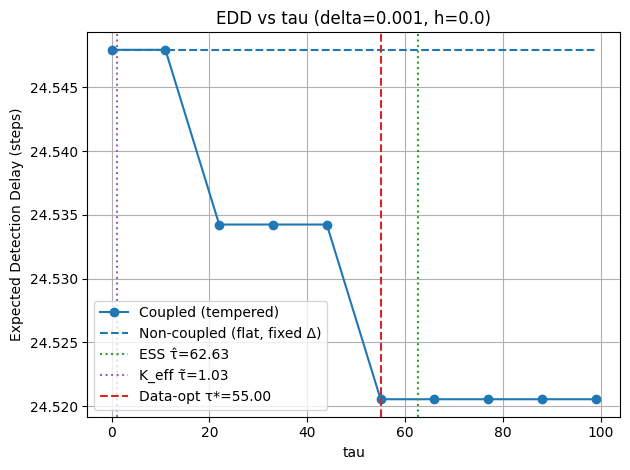

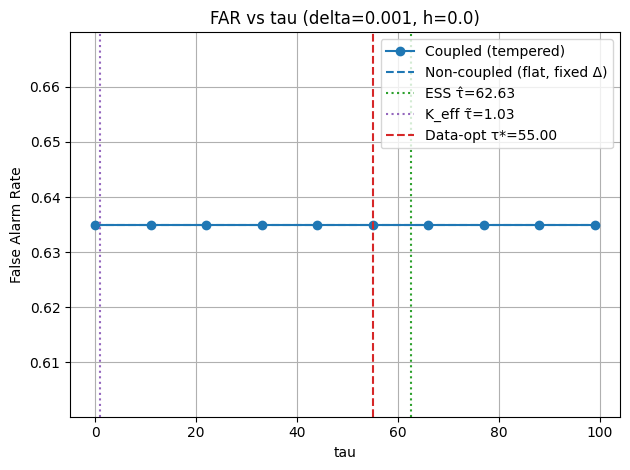

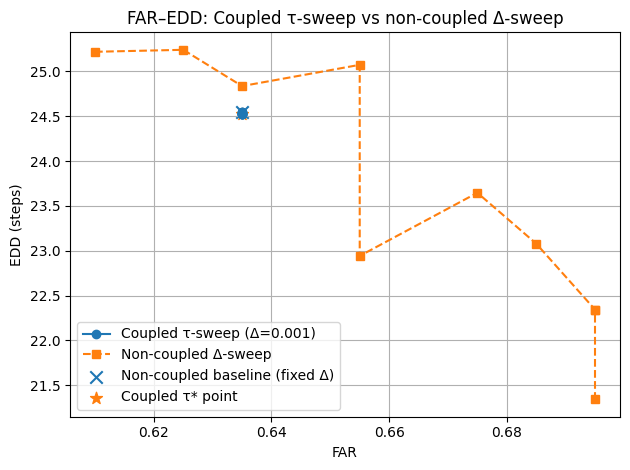

Tau sweep CSV:   tau_sweep_calorimeter_delta_0.001000.csv
Delta sweep CSV: delta_sweep_calorimeter_noncoupled.csv


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

# -------------------------------------------------------------------
# ASSUMPTION: FakeCalorimeter and Configuration are already defined
# -------------------------------------------------------------------
# If they live in a module instead of the current notebook, do:
# from fake_cal import FakeCalorimeter, Configuration

# ---------------------------
# Experiment design
# ---------------------------
J_X = 10       # number of cells in x-direction
J_Y = 10       # number of cells in y-direction
J   = J_X * J_Y

T   = 200     # number of events per run
t0  = 100     # "training" window / nominal changepoint for evaluation

R   = 200     # number of Monte Carlo runs for FAR/EDD estimation

pi        = 1/1000
rho_shrink = 0.8

alpha = 1.0
beta  = 1.0
h     = 0.0

delta_fixed = 0.001
N_TAU       = 10
tau_grid    = np.linspace(0.0, J-1, N_TAU)

delta_grid  = np.logspace(-4, 0, 10)

CLIP_NEG_BF = False

rng_global = np.random.default_rng(31415)

# ---------------------------
# Build binary panel from calorimeter events
# ---------------------------
def build_panel_from_calorimeter(
    n_events,
    config_pre,
    config_post=None,
    t_change=None,
    mode="fault_any",
    rng=None,
):
    """
    Build a J x T binary panel Y from fake calorimeter events.

    n_events : int
        Total number of events T.
    config_pre : Configuration
        Config used before t_change (or all times if config_post is None).
    config_post : Configuration or None
        Config used after t_change, to simulate a distributional change.
    t_change : int or None
        Index in {0,...,T-1} at which we switch to config_post.
        If None or config_post is None, we use config_pre for all t.
    mode : str
        How to define Y_{j,t}=1.
        - "fault_any": 1 if cell is hot OR cold at event t.
        - "hot_only":  1 if cell is hot at event t.
        - "fired_any": 1 if cell has positive energy at event t.
    """
    if rng is None:
        rng = rng_global

    # Instantiate calorimeter with pre-change config
    cal = FakeCalorimeter(config=config_pre)
    X = cal.config.x_size
    Ydim = cal.config.y_size
    J_here = X * Ydim

    if J_here != J:
        raise ValueError(f"Configured J={J} but calorimeter has J={J_here} cells.")

    Y_panel = np.zeros((J_here, n_events), dtype=int)

    for t in range(n_events):
        # Switch to post-change config if applicable
        if (config_post is not None) and (t_change is not None) and (t >= t_change):
            cal.config = config_post

        cal.generate_data()

        if mode == "fault_any":
            cells = set(cal.hot_cells.keys()) | set(cal.cold_cells.keys())
        elif mode == "hot_only":
            cells = set(cal.hot_cells.keys())
        elif mode == "fired_any":
            xs, ys = np.where(cal.cell_energy > 0.0)
            cells = set(zip(xs, ys))
        else:
            raise ValueError(f"Unknown mode {mode!r}")

        for (ix, iy) in cells:
            j = ix * Ydim + iy
            Y_panel[j, t] = 1

    return Y_panel

# ---------------------------
# BOCPD helpers
# ---------------------------
def log_beta_vec(a, b):
    return gammaln(a) + gammaln(b) - gammaln(a + b)

def Amax_all_t(prefix_row, alpha, beta):
    """
    Compute Amax[t] for t=1..T (run starts at r=1).
    Returns array shape (T+1,) 1-based; Amax[1] = -inf (no split possible).
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    m_1t = prefix_row[1:] - prefix_row[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)

    # For each t, maximize over s in {2,...,t}
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)
        # L(1,s-1)
        m_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1 = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)
        # L(s,t)
        m_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)
        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)
    return A

def precompute_tau_invariants(Y, alpha, beta, pi, rho, t0, clip_neg_bf=True):
    """
    Returns:
      A_vals[t,j]: per-series log-evidence (Amax)
      logGM_excl[t,j]: leave-one-out log-geomean base
      logs: (log1mp, logp)
      u_pre[t,j]: u = log X_j(t) for t<=t0 (pre-change), used for tau estimation
    """
    J_here, Tlen = Y.shape
    prefix = np.zeros((J_here, Tlen + 1), dtype=int)
    for j in range(J_here):
        prefix[j, 1:] = np.cumsum(Y[j, :])

    A_vals = np.full((Tlen + 1, J_here), -np.inf, dtype=float)
    for j in range(J_here):
        A_vals[:, j] = Amax_all_t(prefix[j], alpha, beta)

    log1mp, logp = np.log(1 - pi), np.log(pi)

    logGM_excl = np.full((Tlen + 1, J_here), -np.inf, dtype=float)
    u_all = np.full((Tlen + 1, J_here), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF) computed stably
        logX = np.logaddexp(np.log1p(-rho), np.log(rho) + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J_here - 1)

    t0_eff = min(t0, Tlen)
    u_pre = u_all[2:t0_eff+1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre

def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_k u_k(t)).
    """
    if u_pre.size == 0:
        return 0.0
    var_k = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_k))
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff

def estimate_tau_keff_from_corr(u_pre):
    """
    K_eff-based tau: K_eff = (K-1) / (1 + (K-2)*rho_bar),
    where rho_bar is the mean pairwise correlation of Z_k(t)=log X_k(t).
    Returns (tau_keff, rho_bar).
    """
    if u_pre.size == 0:
        return 0.0, np.nan
    T_pre, J_here = u_pre.shape

    C = np.corrcoef(u_pre, rowvar=False)  # J_here x J_here
    off_diag = C[np.triu_indices(J_here, k=1)]
    mask = ~np.isnan(off_diag)
    if not np.any(mask):
        return 0.0, np.nan

    rho_bar = float(np.mean(off_diag[mask]))
    tau_keff = (J_here - 1.0) / (1.0 + (J_here - 2.0) * rho_bar)
    tau_keff = max(0.0, min(tau_keff, J_here - 1.0))
    return tau_keff, rho_bar

def first_alarm_from_scores(S, h=0.0):
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan

def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau, h=0.0):
    """
    For fixed tau, build logLambda and return (t_alarm_coupled, t_alarm_noncoupled)
    """
    log1mp, logp = logs
    Tlen, J_here = A_vals.shape[0]-1, A_vals.shape[1]

    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta*delta) - (np.log(t+1) + np.log(np.log(t+1)))
    logeta[:2] = -np.inf

    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c, h), first_alarm_from_scores(S_n, h)

def alarm_noncoupled_delta(A_vals, delta, h=0.0):
    """
    Non-coupled detector with arbitrary delta.
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n, h)

# ---------------------------
# Monte Carlo over calorimeter runs
# ---------------------------
precomp_list = []
tau_ess_runs  = []
tau_keff_runs = []
rho_bar_runs  = []

# Define pre- and post-change configs for calorimeter
config_pre  = Configuration(x_size=J_X, y_size=J_Y)
config_post = Configuration(x_size=J_X, y_size=J_Y)
# Example: increase fault probabilities post-change (tweak as needed)
config_post.p_cell_hot       = config_pre.p_cell_hot * 5.0
config_post.p_cell_block_hot = config_pre.p_cell_block_hot * 5.0

for r in range(R):
    Y_run = build_panel_from_calorimeter(
        n_events=T,
        config_pre=config_pre,
        config_post=config_post,
        t_change=t0,
        mode="fault_any",   # or "hot_only", "fired_any"
        rng=rng_global,
    )

    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants(
        Y_run, alpha, beta, pi, rho_shrink, t0,
        clip_neg_bf=CLIP_NEG_BF,
    )
    tau_ess = estimate_tau_ess_from_u(u_pre)
    tau_keff, rho_bar = estimate_tau_keff_from_corr(u_pre)

    tau_ess_runs.append(tau_ess)
    tau_keff_runs.append(tau_keff)
    rho_bar_runs.append(rho_bar)
    precomp_list.append((A_vals, logGM_excl, logs))

tau_hat_ESS  = float(np.median(tau_ess_runs))
tau_hat_KEFF = float(np.median(tau_keff_runs))
rho_bar_med  = float(np.nanmedian(rho_bar_runs))

print(f"Estimated tau (ESS, median over runs):   {tau_hat_ESS:.3f}")
print(f"Estimated tau (K_eff, median over runs): {tau_hat_KEFF:.3f}")
print(f"Median pairwise rho_bar over runs:       {rho_bar_med:.4f}")

# ---------------------------
# Sweep tau (coupled) at fixed delta
# ---------------------------
rows = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau, h=h)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results = pd.DataFrame(rows)

# ---------------------------
# Data-optimal tau at target FAR (non-coupled baseline, fixed delta)
# ---------------------------
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")
far_baseline = results.loc[mask_n_fixed, "FAR"].iloc[0]

coupled = results[results["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]
if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")

# ---------------------------
# Extra experiment: delta-sweep for NON-COUPLED detector
# ---------------------------
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h=h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)

    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]
    if at.size > 0:
        far = float(np.mean(at < t0))
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size),
    })

results_delta = pd.DataFrame(rows_delta)

# Combine for plotting
results_all = pd.concat([results, results_delta], ignore_index=True)

# ---------------------------
# Plots
# ---------------------------
mask_c = (results["detector"] == "coupled_tempered")
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS,  color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, color="tab:purple", linestyle=":",
            label=f"K_eff τ̃={tau_hat_KEFF:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS,  color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, color="tab:purple", linestyle=":",
            label=f"K_eff τ̃={tau_hat_KEFF:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# FAR–EDD parametric curves
mask_c_all   = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g})")
plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep")

plt.scatter(results.loc[mask_n_fixed, "FAR"].iloc[0],
            results.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

if np.isfinite(tau_star):
    row_star = coupled.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD: Coupled τ-sweep vs non-coupled Δ-sweep")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save CSVs
out_path_tau   = f"tau_sweep_calorimeter_delta_{delta_fixed:.6f}.csv"
out_path_delta = "delta_sweep_calorimeter_noncoupled.csv"
results.to_csv(out_path_tau, index=False)
results_delta.to_csv(out_path_delta, index=False)
print(f"Tau sweep CSV:   {out_path_tau}")
print(f"Delta sweep CSV: {out_path_delta}")


In [20]:
pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 14.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [30]:
import numpy as np

# -------------------------------------------------------------------
# ASSUMPTION: Configuration and FakeCalorimeter are already defined
# -------------------------------------------------------------------
# from fake_cal import Configuration, FakeCalorimeter  # if in a module


# ===== 1. Basic setup: 5×5 calorimeter, T events =====
T = 100  # number of events (time points)
config = Configuration(x_size=5, y_size=5)
cal = FakeCalorimeter(config=config)

X = cal.X          # 5
Y = cal.Y          # 5
J = X * Y          # 25 series


# ===== 2. Storage arrays =====
# energy_cube[t, ix, iy] = energy in cell (ix, iy) at event t
energy_cube = np.zeros((T, X, Y), dtype=np.float32)

# Booleans telling us if a cell is hot/cold/fired in event t
is_hot   = np.zeros((T, X, Y), dtype=bool)
is_cold  = np.zeros((T, X, Y), dtype=bool)
is_fired = np.zeros((T, X, Y), dtype=bool)


# ===== 3. Generate events and fill arrays =====
for t in range(T):
    cal.generate_data()

    # energies
    energy_cube[t] = cal.cell_energy  # shape (X, Y)

    # hot / cold: these are persistent sets of cells in error
    #   hot_cells : dict[(x, y)] -> fixed hot-energy mean
    #   cold_cells: dict[(x, y)] -> 0.0
    for (ix, iy), _E in cal.hot_cells.items():
        is_hot[t, ix, iy] = True

    for (ix, iy), _E in cal.cold_cells.items():
        is_cold[t, ix, iy] = True

    # cells_fired is per-event (normal hits)
    for (ix, iy) in cal.cells_fired:
        is_fired[t, ix, iy] = True


print("energy_cube.shape:", energy_cube.shape)  # (T, 5, 5)


# ===== 4. Build binary panel for changepoint code =====
# Example 0/1 indicator: cell is in error (hot OR cold) at time t
fault_any = np.logical_or(is_hot, is_cold)      # shape (T, X, Y)

# Flatten to panel Y_panel[j, t] with j = ix * Y + iy
Y_panel = fault_any.transpose(1, 2, 0).reshape(J, T).astype(int)

print("Y_panel.shape:", Y_panel.shape)         # (25, T)

# Example: map series index j back to (ix, iy)
j = 7
ix, iy = divmod(j, Y)
print(f"Series j={j} corresponds to cell (ix={ix}, iy={iy})")


# ===== 5. Simple group structure =====
# For now: all 25 cells belong to one global group (group 0).
group_labels = np.zeros(J, dtype=int)  # length 25, all zeros

# If you later want, for example, row-wise groups:
#   group_labels = np.repeat(np.arange(X), Y)
# so row 0 (cells (0,0)...(0,4)) = group 0, row 1 = group 1, etc.


# ===== 6. Examples of access =====
# Time series of raw energies for cell (2, 4):
ts_energy_2_4 = energy_cube[:, 2, 4]  # length T

# Binary time series "fault_any" for same cell:
ts_fault_any_2_4 = fault_any[:, 2, 4].astype(int)

# Same via flattened panel: j index for (2,4)
j_2_4 = 2 * Y + 4
ts_fault_any_2_4_panel = Y_panel[j_2_4]  # should match ts_fault_any_2_4


energy_cube.shape: (100, 5, 5)
Y_panel.shape: (25, 100)
Series j=7 corresponds to cell (ix=1, iy=2)


In [42]:
import numpy as np
from scipy.special import gammaln

# ============================================================
# 1. Helper: build a 5×5 panel Y_panel[j, t] from calorimeter
# ============================================================
def build_panel_from_calorimeter(
    n_events,
    config_pre,
    config_post=None,
    t_change=None,
    mode="fault_any",
):
    """
    Simulate n_events from FakeCalorimeter and return a 0/1 panel Y_panel.

    - n_events: number of events (T)
    - config_pre: Configuration used before t_change
    - config_post: Configuration used after t_change (if None, no change)
    - t_change: index in {0,...,T-1} where we switch config to config_post
    - mode:
        "fault_any": 1 if cell is hot OR cold at this event
        "hot_only" : 1 if cell is hot
        "cold_only": 1 if cell is cold
    Returns:
        Y_panel: array of shape (J, T) with J = x_size * y_size
    """
    cal = FakeCalorimeter(config=config_pre)
    X, Y = cal.X, cal.Y
    J = X * Y
    T = n_events

    # storage: per-event hot/cold flags
    is_hot  = np.zeros((T, X, Y), dtype=bool)
    is_cold = np.zeros((T, X, Y), dtype=bool)

    for t in range(T):
        # switch to post-change config if applicable
        if config_post is not None and t_change is not None and t >= t_change:
            cal.config = config_post

        cal.generate_data()

        # mark which cells are hot/cold at this event
        for (ix, iy), _E in cal.hot_cells.items():
            is_hot[t, ix, iy] = True
        for (ix, iy), _E in cal.cold_cells.items():
            is_cold[t, ix, iy] = True

    if mode == "fault_any":
        indicator = np.logical_or(is_hot, is_cold)
    elif mode == "hot_only":
        indicator = is_hot
    elif mode == "cold_only":
        indicator = is_cold
    else:
        raise ValueError(f"Unknown mode={mode!r}")

    # Flatten (T, X, Y) -> (J, T) with j = ix * Y + iy
    Y_panel = indicator.transpose(1, 2, 0).reshape(J, T).astype(int)
    return Y_panel


# =====================================
# 2. Amax for each series (uncoupled)
# =====================================
def log_beta_vec(a, b):
    return gammaln(a) + gammaln(b) - gammaln(a + b)

def Amax_all_t(prefix_row, alpha, beta):
    """
    Compute Amax[t] for t=1..T for ONE series.
    Returns array A of shape (T+1,), 1-based in t, A[1] = -inf (no split).
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # L(1,t) for all t
    m_1t   = prefix_row[1:] - prefix_row[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t   = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)

    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)
        # L(1, s-1)
        m_1_sm1   = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1   = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)
        # L(s, t)
        m_s_t   = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t   = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)

        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)

    return A

def compute_A_vals_panel(Y_panel, alpha=1.0, beta=1.0):
    """
    Y_panel: J x T (0/1)
    Returns A_vals of shape (T+1, J) with per-series Amax[t, j]
    """
    J, Tlen = Y_panel.shape
    prefix = np.zeros((J, Tlen + 1), dtype=int)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(Y_panel[j, :])

    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t(prefix_row=prefix[j], alpha=alpha, beta=beta)
    return A_vals


# ==========================================
# 3. Uncoupled hazard & alarm time (global)
# ==========================================
def first_alarm_from_scores(S, h=0.0):
    """
    S: (T+1, J) matrix of scores.
    Returns first t where ANY series triggers S[t, j] >= h.
    """
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan

def alarm_noncoupled_delta(A_vals, delta, h=0.0):
    """
    Non-coupled detector with hazard spending delta.
    A_vals: (T+1, J) log-evidence
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf  # no hazard at t<2

    S_n = A_vals + logeta[:, None]  # broadcast over J
    return first_alarm_from_scores(S_n, h=h)


# ==========================================
# 4. Put it together: one run, uncoupled
# ==========================================
# --- Calorimeter configs: pre- and post-change ---
config_pre = Configuration(x_size=5, y_size=5)

# Make a slightly more "faulty" config after the change:
config_post = Configuration(
    x_size=5,
    y_size=5,
    p_cell_hot       = config_pre.p_cell_hot * 5.0,
    p_cell_hot_fires = config_pre.p_cell_hot_fires,  # keep same firing prob
    p_cell_cold      = config_pre.p_cell_cold * 5.0,
    p_cell_cold_fires= config_pre.p_cell_cold_fires,
    block_size_x     = config_pre.block_size_x,
    block_size_y     = config_pre.block_size_y,
    p_cell_block_hot = config_pre.p_cell_block_hot * 5.0,
    p_cell_block_cold= config_pre.p_cell_block_cold * 5.0,
)

T    = 200   # total events
t0   = 100   # true change time (when we switch to config_post)
delta = 1e-3
h     = 0.0
alpha = 1.0
beta  = 1.0

# --- Generate one 5×5 panel with a change at t0 ---
Y_panel = build_panel_from_calorimeter(
    n_events=T,
    config_pre=config_pre,
    config_post=config_post,
    t_change=t0,
    mode="fault_any",   # 1 if cell is hot OR cold
)

print("Y_panel shape:", Y_panel.shape)  # (25, 200)

# --- Compute per-series log-evidence Amax ---
A_vals = compute_A_vals_panel(Y_panel, alpha=alpha, beta=beta)

# --- Run uncoupled hazard detector ---
t_alarm = alarm_noncoupled_delta(A_vals, delta=delta, h=h)

print(f"True change time:   t0 = {t0}")
print(f"Uncoupled alarm at: t* = {t_alarm}")
if np.isfinite(t_alarm):
    print(f"Detection delay:      t* - t0 = {t_alarm - t0}")
else:
    print("No alarm was triggered.")


Y_panel shape: (25, 200)
True change time:   t0 = 100
Uncoupled alarm at: t* = 134.0
Detection delay:      t* - t0 = 34.0


          delta  FAR        EDD  EDD_median  n_alarms  n_post
0  1.000000e-20  0.0  71.341270        68.0       126     126
1  1.804722e-20  0.0  70.246032        67.0       126     126
2  3.257021e-20  0.0  69.453125        67.0       128     128
3  5.878016e-20  0.0  68.480620        67.0       129     129
4  1.060818e-19  0.0  67.446154        65.0       130     130


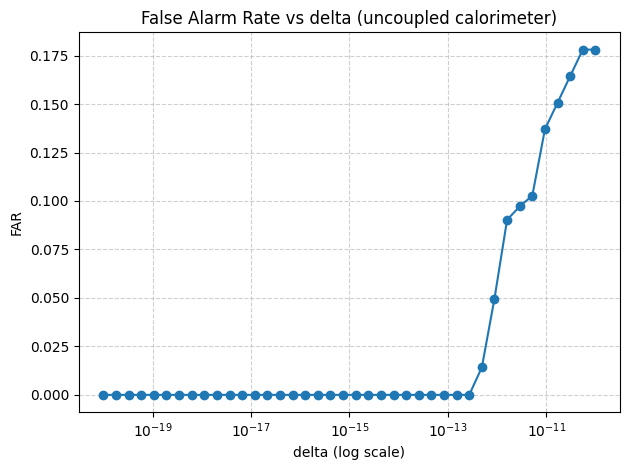

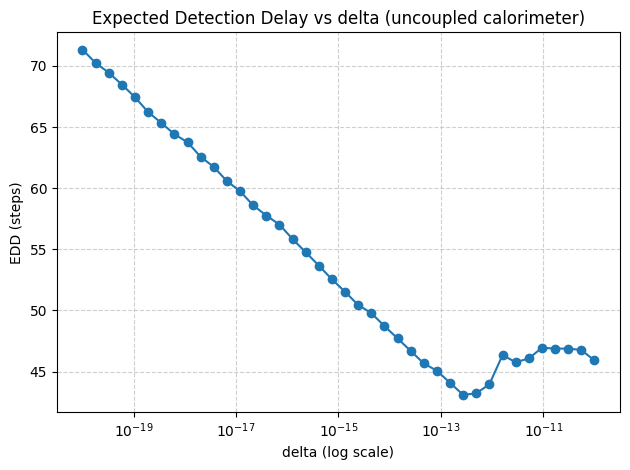

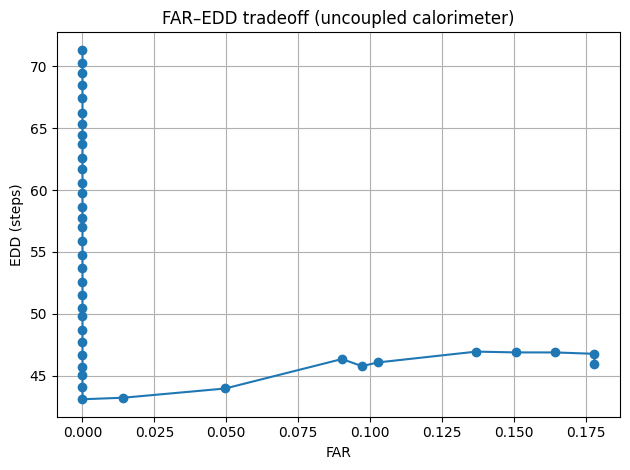

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

# ============================================================
# 1. Build a 5×5 binary panel Y_panel[j, t] from calorimeter
# ============================================================
def build_panel_from_calorimeter(
    n_events,
    config_pre,
    config_post=None,
    t_change=None,
    mode="fault_any",
):
    """
    Simulate n_events from FakeCalorimeter and return a 0/1 panel Y_panel.

    Parameters
    ----------
    n_events : int
        Number of events (T).
    config_pre : Configuration
        Config used before t_change.
    config_post : Configuration or None
        Config used after t_change (if None, no distributional change).
    t_change : int or None
        Time index in {0,...,T-1} where we switch to config_post.
        If None or config_post is None, use config_pre for all t.
    mode : {"fault_any", "hot_only", "cold_only"}
        How to define the binary indicator per cell and time.

    Returns
    -------
    Y_panel : (J, T) int array
        Binary panel: J = x_size * y_size series, length T.
    """
    cal = FakeCalorimeter(config=config_pre)
    X, Y = cal.X, cal.Y
    J = X * Y
    T = n_events

    is_hot  = np.zeros((T, X, Y), dtype=bool)
    is_cold = np.zeros((T, X, Y), dtype=bool)

    for t in range(T):
        # Switch to post-change config if applicable
        if config_post is not None and t_change is not None and t >= t_change:
            cal.config = config_post

        cal.generate_data()

        # Mark hot/cold status at this event
        for (ix, iy), _E in cal.hot_cells.items():
            is_hot[t, ix, iy] = True
        for (ix, iy), _E in cal.cold_cells.items():
            is_cold[t, ix, iy] = True

    if mode == "fault_any":
        indicator = np.logical_or(is_hot, is_cold)
    elif mode == "hot_only":
        indicator = is_hot
    elif mode == "cold_only":
        indicator = is_cold
    else:
        raise ValueError(f"Unknown mode={mode!r}")

    # Flatten (T, X, Y) -> (J, T) with j = ix * Y + iy
    Y_panel = indicator.transpose(1, 2, 0).reshape(J, T).astype(int)
    return Y_panel


# ============================================================
# 2. Amax computation for each series (uncoupled)
# ============================================================
def log_beta_vec(a, b):
    return gammaln(a) + gammaln(b) - gammaln(a + b)

def Amax_all_t(prefix_row, alpha, beta):
    """
    Compute Amax[t] for t=1..T for ONE series.
    Returns array A of shape (T+1,), 1-based in t, A[1] = -inf (no split).
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # L(1,t) for all t
    m_1t   = prefix_row[1:] - prefix_row[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t   = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)

    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # L(1, s-1)
        m_1_sm1   = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1   = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)

        # L(s, t)
        m_s_t   = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t   = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)

        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)

    return A

def compute_A_vals_panel(Y_panel, alpha=1.0, beta=1.0):
    """
    Y_panel: J x T (0/1)
    Returns A_vals of shape (T+1, J) with per-series Amax[t, j]
    """
    J, Tlen = Y_panel.shape
    prefix = np.zeros((J, Tlen + 1), dtype=int)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(Y_panel[j, :])

    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t(prefix_row=prefix[j], alpha=alpha, beta=beta)
    return A_vals


# ============================================================
# 3. Uncoupled hazard, alarm time, and summaries
# ============================================================
def first_alarm_from_scores(S, h=0.0):
    """
    S: (T+1, J) matrix of scores.
    Returns first t where ANY series triggers S[t, j] >= h.
    """
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan

def alarm_noncoupled_delta(A_vals, delta, h=0.0):
    """
    Non-coupled detector with hazard spending delta.
    A_vals: (T+1, J) log-evidence
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf  # no hazard at t<2

    S_n = A_vals + logeta[:, None]  # broadcast over J
    return first_alarm_from_scores(S_n, h=h)


# ============================================================
# 4. Monte Carlo experiment: FAR & EDD vs delta
# ============================================================
# --- experiment settings ---
T     = 200    # total number of events per run
t0    = 100    # true change time (switch pre -> post)
R     = 200    # number of Monte Carlo runs
alpha = 1.0
beta  = 1.0
h     = 0.0

# delta grid to explore
delta_grid = np.logspace(-20, -10, 40)  # you can tweak range / resolution

# --- calorimeter configs: pre- and post-change ---
config_pre = Configuration(x_size=5, y_size=5)

# Post-change: more likely to produce hot/cold cells
config_post = Configuration(
    x_size=5,
    y_size=5,
    max_number_of_clusters=config_pre.max_number_of_clusters,
    max_cells_per_cluster=config_pre.max_cells_per_cluster,
    p_cell_hot       = config_pre.p_cell_hot * 5.0,
    p_cell_hot_fires = config_pre.p_cell_hot_fires,
    p_cell_cold      = config_pre.p_cell_cold * 5.0,
    p_cell_cold_fires= config_pre.p_cell_cold_fires,
    block_size_x     = config_pre.block_size_x,
    block_size_y     = config_pre.block_size_y,
    p_cell_block_hot = config_pre.p_cell_block_hot * 5.0,
    p_cell_block_cold= config_pre.p_cell_block_cold * 5.0,
)

# --- precompute A_vals for all runs (so deltas share the same simulated panels) ---
precomp_A_vals = []

for r in range(R):
    Y_panel = build_panel_from_calorimeter(
        n_events=T,
        config_pre=config_pre,
        config_post=config_post,
        t_change=t0,
        mode="fault_any",  # 1 if hot OR cold
    )
    A_vals = compute_A_vals_panel(Y_panel, alpha=alpha, beta=beta)
    precomp_A_vals.append(A_vals)

# --- sweep delta, compute FAR and EDD over runs ---
rows = []

for delta in delta_grid:
    alarm_times = []

    for A_vals in precomp_A_vals:
        t_alarm = alarm_noncoupled_delta(A_vals, delta=delta, h=h)
        alarm_times.append(t_alarm)

    alarm_times = np.array(alarm_times)

    finite = np.isfinite(alarm_times)
    at = alarm_times[finite]

    if at.size > 0:
        # False alarm indicator: alarm before true change
        far = float(np.mean(at < t0))

        # Detection delays for alarms that happen after t0
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan

    rows.append({
        "delta": delta,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_alarms": int(at.size),
        "n_post": int(dd.size if at.size > 0 else 0),
    })

results = pd.DataFrame(rows)
print(results.head())

# ============================================================
# 5. Optional: plot FAR vs delta and EDD vs delta
# ============================================================
plt.figure()
plt.semilogx(results["delta"], results["FAR"], marker="o")
plt.xlabel("delta (log scale)")
plt.ylabel("FAR")
plt.title("False Alarm Rate vs delta (uncoupled calorimeter)")
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure()
plt.semilogx(results["delta"], results["EDD"], marker="o")
plt.xlabel("delta (log scale)")
plt.ylabel("EDD (steps)")
plt.title("Expected Detection Delay vs delta (uncoupled calorimeter)")
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# ============================================================
# 6. Optional: FAR–EDD parametric curve
# ============================================================
plt.figure()
plt.plot(results["FAR"], results["EDD"], marker="o")
plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD tradeoff (uncoupled calorimeter)")
plt.grid(True)
plt.tight_layout()
plt.show()


Estimated tau (ESS, median):   1.000
Estimated tau (K_eff, median): 1.000
Median rho_bar (log X):        1.0000
Data-optimal tau at FAR<=baseline: 1.220  (EDD=58.336)


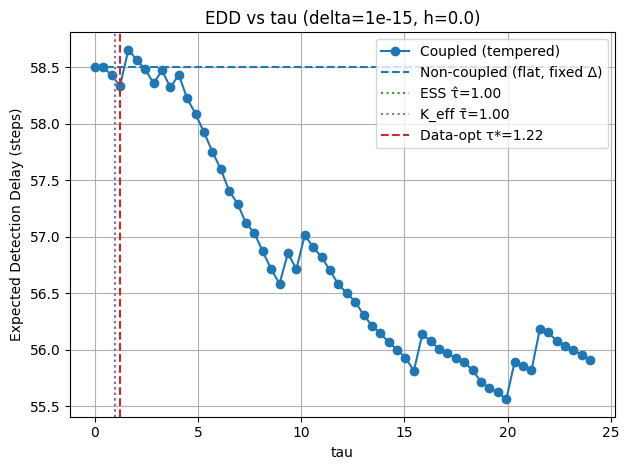

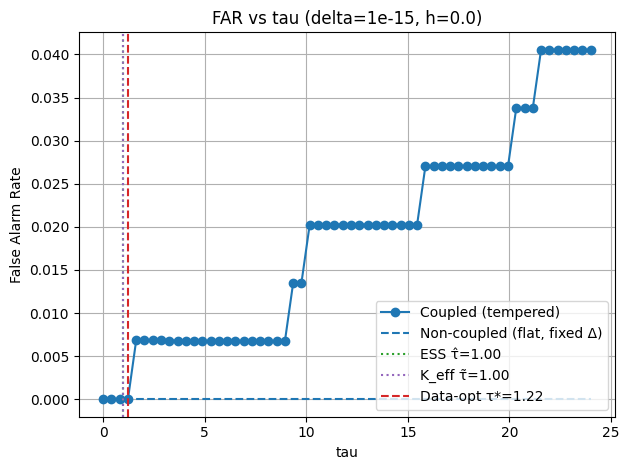

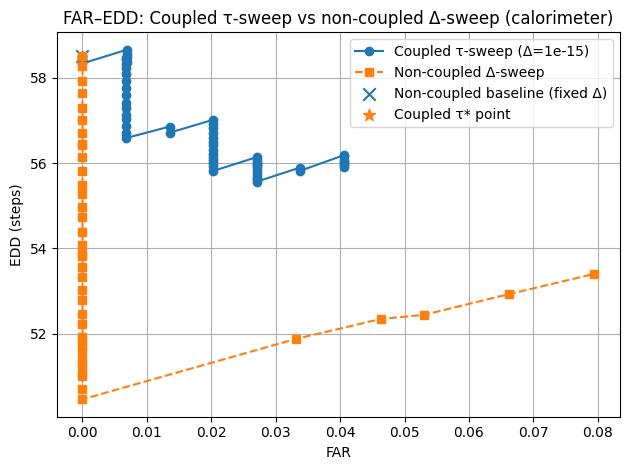

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

# ============================================================
# 1. Build a 5×5 binary panel Y_panel[j, t] from calorimeter
# ============================================================
def build_panel_from_calorimeter(
    n_events,
    config_pre,
    config_post=None,
    t_change=None,
    mode="fault_any",
):
    """
    Simulate n_events from FakeCalorimeter and return a 0/1 panel Y_panel.

    Parameters
    ----------
    n_events : int
        Number of events (T).
    config_pre : Configuration
        Config used before t_change.
    config_post : Configuration or None
        Config used after t_change (if None, no distributional change).
    t_change : int or None
        Time index in {0,...,T-1} where we switch to config_post.
        If None or config_post is None, use config_pre for all t.
    mode : {"fault_any", "hot_only", "cold_only"}
        How to define the binary indicator per cell and time.

    Returns
    -------
    Y_panel : (J, T) int array
        Binary panel: J = x_size * y_size series, length T.
    """
    cal = FakeCalorimeter(config=config_pre)
    X, Y = cal.X, cal.Y
    J = X * Y
    T = n_events

    is_hot  = np.zeros((T, X, Y), dtype=bool)
    is_cold = np.zeros((T, X, Y), dtype=bool)

    for t in range(T):
        # Switch to post-change config if applicable
        if config_post is not None and t_change is not None and t >= t_change:
            cal.config = config_post

        cal.generate_data()

        # Mark hot/cold status at this event
        for (ix, iy), _E in cal.hot_cells.items():
            is_hot[t, ix, iy] = True
        for (ix, iy), _E in cal.cold_cells.items():
            is_cold[t, ix, iy] = True

    if mode == "fault_any":
        indicator = np.logical_or(is_hot, is_cold)
    elif mode == "hot_only":
        indicator = is_hot
    elif mode == "cold_only":
        indicator = is_cold
    else:
        raise ValueError(f"Unknown mode={mode!r}")

    # Flatten (T, X, Y) -> (J, T) with j = ix * Y + iy
    Y_panel = indicator.transpose(1, 2, 0).reshape(J, T).astype(int)
    return Y_panel


# ============================================================
# 2. Amax computation + invariants for coupling
# ============================================================
def log_beta_vec(a, b):
    return gammaln(a) + gammaln(b) - gammaln(a + b)

def Amax_all_t(prefix_row, alpha, beta):
    """
    Compute Amax[t] for t=1..T for ONE series.
    Returns array A of shape (T+1,), 1-based in t, A[1] = -inf (no split).
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # L(1,t) for all t
    m_1t   = prefix_row[1:] - prefix_row[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t   = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)

    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # L(1, s-1)
        m_1_sm1   = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1   = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)

        # L(s, t)
        m_s_t   = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t   = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)

        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)

    return A

def precompute_tau_invariants(Y_panel, alpha, beta, pi, rho_shrink, t0, clip_neg_bf=True):
    """
    For a given panel Y_panel (J x T), precompute:

      - A_vals[t,j]: per-series log-evidence (Amax)
      - logGM_excl[t,j]: leave-one-out log-geomean base
      - logs: (log1mp, logp) for mixing with prior pi
      - u_pre: log X_j(t) for t<=t0, used for tau estimation

    Shapes:
      Y_panel: (J, T)
      A_vals: (T+1, J)
      logGM_excl: (T+1, J)
      u_pre: (Tpre, J), Tpre = min(t0, T)-1 essentially.
    """
    J, Tlen = Y_panel.shape
    prefix = np.zeros((J, Tlen + 1), dtype=int)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(Y_panel[j, :])

    # Amax per series
    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t(prefix_row=prefix[j], alpha=alpha, beta=beta)

    log1mp, logp = np.log(1 - pi), np.log(pi)

    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    u_all = np.full((Tlen + 1, J), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)

        # logX = log((1-ρ) + ρ * BF) computed stably
        logX = np.logaddexp(np.log1p(-rho_shrink), np.log(rho_shrink) + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)

    # Pre-change slice for tau estimation
    t0_eff = min(t0, Tlen)
    u_pre = u_all[2:t0_eff+1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre


# ============================================================
# 3. Tau estimators: ESS and K_eff
# ============================================================
def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_k u_k(t)).
    u_pre: (Tpre, J) array of log X's in pre-change window.
    """
    if u_pre.size == 0:
        return 0.0
    var_k = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_k))
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff

def estimate_tau_keff_from_corr(u_pre):
    """
    K_eff-based tau: K_eff = (K-1) / (1 + (K-2)*rho_bar),
    where rho_bar is the mean pairwise correlation of Z_k(t)=log X_k(t).
    Returns (tau_keff, rho_bar).
    """
    if u_pre.size == 0:
        return 0.0, np.nan
    T_pre, J_here = u_pre.shape

    C = np.corrcoef(u_pre, rowvar=False)  # J_here x J_here
    off_diag = C[np.triu_indices(J_here, k=1)]
    mask = ~np.isnan(off_diag)
    if not np.any(mask):
        return 0.0, np.nan

    rho_bar = float(np.mean(off_diag[mask]))
    tau_keff = (J_here - 1.0) / (1.0 + (J_here - 2.0) * rho_bar)
    tau_keff = max(0.0, min(tau_keff, J_here - 1.0))
    return tau_keff, rho_bar


# ============================================================
# 4. Coupled & non-coupled alarm functions
# ============================================================
def first_alarm_from_scores(S, h=0.0):
    """
    S: (T+1, J) matrix of scores.
    Returns first t where ANY series triggers S[t, j] >= h.
    """
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan

def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau, h=0.0):
    """
    For fixed tau, build logLambda and return (t_alarm_coupled, t_alarm_noncoupled)
    using the SAME delta.

    A_vals: (T+1, J) log-evidence
    logGM_excl: (T+1, J) leave-one-out log-geomean
    logs: (log1mp, logp) prior odds for group
    """
    log1mp, logp = logs
    Tlen, J = A_vals.shape[0]-1, A_vals.shape[1]

    # hazard spending
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    # group-coupling factor
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    # scores
    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c, h=h), first_alarm_from_scores(S_n, h=h)

def alarm_noncoupled_delta(A_vals, delta, h=0.0):
    """
    Pure non-coupled detector with arbitrary delta.
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n, h=h)


# ============================================================
# 5. Monte Carlo experiment: coupled vs non-coupled
# ============================================================
# --- experiment settings ---
T     = 200    # total events per run
t0    = 100    # change time (switch pre -> post config)
R     = 200    # Monte Carlo runs

alpha = 1.0
beta  = 1.0
pi    = 1/1000
rho_shrink = 0.8
h     = 0.0

delta_fixed = 1e-15          # base delta for coupled vs non-coupled comparison
tau_grid    = np.linspace(0.0, 24.0, 60)   # tau in [0, J-1] for J=25

# extra delta grid for non-coupled delta-sweep comparison
delta_grid  = np.logspace(-15, -12, 40)

CLIP_NEG_BF = False

# --- calorimeter configs: pre- and post-change ---
config_pre = Configuration(x_size=5, y_size=5)

config_post = Configuration(
    x_size=5,
    y_size=5,
    max_number_of_clusters=config_pre.max_number_of_clusters,
    max_cells_per_cluster=config_pre.max_cells_per_cluster,
    p_cell_hot       = config_pre.p_cell_hot * 5.0,
    p_cell_hot_fires = config_pre.p_cell_hot_fires,
    p_cell_cold      = config_pre.p_cell_cold * 5.0,
    p_cell_cold_fires= config_pre.p_cell_cold_fires,
    block_size_x     = config_pre.block_size_x,
    block_size_y     = config_pre.block_size_y,
    p_cell_block_hot = config_pre.p_cell_block_hot * 5.0,
    p_cell_block_cold= config_pre.p_cell_block_cold * 5.0,
)

# --- precompute invariants and tau estimates per run ---
precomp_list = []
tau_ess_runs  = []
tau_keff_runs = []
rho_bar_runs  = []

for r in range(R):
    Y_panel = build_panel_from_calorimeter(
        n_events=T,
        config_pre=config_pre,
        config_post=config_post,
        t_change=t0,
        mode="fault_any",
    )
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants(
        Y_panel,
        alpha=alpha,
        beta=beta,
        pi=pi,
        rho_shrink=rho_shrink,
        t0=t0,
        clip_neg_bf=CLIP_NEG_BF,
    )
    tau_ess  = estimate_tau_ess_from_u(u_pre)
    tau_keff, rho_bar = estimate_tau_keff_from_corr(u_pre)

    tau_ess_runs.append(tau_ess)
    tau_keff_runs.append(tau_keff)
    rho_bar_runs.append(rho_bar)
    precomp_list.append((A_vals, logGM_excl, logs))

tau_hat_ESS  = float(np.median(tau_ess_runs))
tau_hat_KEFF = float(np.median(tau_keff_runs))
rho_bar_med  = float(np.nanmedian(rho_bar_runs))

print(f"Estimated tau (ESS, median):   {tau_hat_ESS:.3f}")
print(f"Estimated tau (K_eff, median): {tau_hat_KEFF:.3f}")
print(f"Median rho_bar (log X):        {rho_bar_med:.4f}")

# --- sweep tau at fixed delta for coupled vs fixed-delta non-coupled ---
rows = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau, h=h)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd  = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results = pd.DataFrame(rows)

# baseline FAR from fixed-delta non-coupled
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")
far_baseline = results.loc[mask_n_fixed, "FAR"].iloc[0]

coupled_df = results[results["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled_df[coupled_df["FAR"] <= far_baseline + tol]
if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")

# --- delta-sweep for NON-COUPLED detector (for FAR–EDD comparison) ---
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h=h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)
    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]

    if at.size > 0:
        far = float(np.mean(at < t0))
        dd  = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size if at.size > 0 else 0),
    })

results_delta = pd.DataFrame(rows_delta)

# Combine all for FAR–EDD plot
results_all = pd.concat([results, results_delta], ignore_index=True)

# ============================================================
# 6. Plots: EDD vs tau and FAR vs tau for coupled vs non-coupled
# ============================================================
mask_c = (results["detector"] == "coupled_tempered")
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS,  color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, color="tab:purple", linestyle=":",
            label=f"K_eff τ̃={tau_hat_KEFF:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS,  color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, color="tab:purple", linestyle=":",
            label=f"K_eff τ̃={tau_hat_KEFF:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# 7. FAR–EDD parametric curve: coupled τ-sweep vs non-coupled Δ-sweep
# ============================================================
mask_c_all   = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g})")
plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep")

# Mark the fixed-delta non-coupled baseline point
plt.scatter(results.loc[mask_n_fixed, "FAR"].iloc[0],
            results.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# Mark τ* if available
if np.isfinite(tau_star):
    row_star = coupled_df.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD: Coupled τ-sweep vs non-coupled Δ-sweep (calorimeter)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

# ============================================================
# 0. Configure calorimeter so whole rows become "units"
# ============================================================
# Each block is 1 x 5 (a row), and only blocks go faulty (no indiv cells).
config_pre = Configuration(
    x_size=5,
    y_size=5,
    # leave cluster parameters at defaults
    p_cell_hot=0.0,
    p_cell_cold=0.0,
    block_size_x=1,
    block_size_y=5,
    p_cell_block_hot=0.01,
    p_cell_block_cold=0.01,
)

# Post-change: make row-block faults much more likely (stronger coupling)
config_post = Configuration(
    x_size=5,
    y_size=5,
    p_cell_hot=0.0,
    p_cell_cold=0.0,
    block_size_x=1,
    block_size_y=5,
    p_cell_block_hot=config_pre.p_cell_block_hot * 5.0,
    p_cell_block_cold=config_pre.p_cell_block_cold * 5.0,
)

# ============================================================
# 1. Build a 5-unit panel Y_unit[u, t] from calorimeter rows
# ============================================================
def build_unit_panel(
    n_events,
    config_pre,
    config_post=None,
    t_change=None,
    mode="fault_any",
):
    """
    Simulate n_events from FakeCalorimeter and return a 0/1 *unit* panel Y_unit.

    Units = rows: u = 0,...,X-1, each row contains all Y cells.

    Parameters
    ----------
    n_events : int
        Number of events (T).
    config_pre : Configuration
        Config used before t_change.
    config_post : Configuration or None
        Config used after t_change (if None, no distributional change).
    t_change : int or None
        Time index in {0,...,T-1} where we switch to config_post.
    mode : {"fault_any", "hot_only", "cold_only"}
        How to define the binary indicator per cell and time.

    Returns
    -------
    Y_unit : (U, T) int array
        Binary panel at unit (row) level: U = x_size.
        Y_unit[u, t] = 1 iff any cell in row u is faulty at t.
    """
    cal = FakeCalorimeter(config=config_pre)
    X, Y = cal.X, cal.Y
    T = n_events

    is_hot  = np.zeros((T, X, Y), dtype=bool)
    is_cold = np.zeros((T, X, Y), dtype=bool)

    for t in range(T):
        if config_post is not None and t_change is not None and t >= t_change:
            cal.config = config_post

        cal.generate_data()

        for (ix, iy), _E in cal.hot_cells.items():
            is_hot[t, ix, iy] = True
        for (ix, iy), _E in cal.cold_cells.items():
            is_cold[t, ix, iy] = True

    if mode == "fault_any":
        indicator = np.logical_or(is_hot, is_cold)  # (T, X, Y)
    elif mode == "hot_only":
        indicator = is_hot
    elif mode == "cold_only":
        indicator = is_cold
    else:
        raise ValueError(f"Unknown mode={mode!r}")

    # Aggregate to row-units: any faulty cell in row u at event t
    # indicator[t, ix, iy] -> row_fault[t, ix] = any_y indicator[t, ix, y]
    row_fault = indicator.any(axis=2)   # (T, X)
    Y_unit = row_fault.T.astype(int)    # (X, T) = (U, T)

    return Y_unit   # unit-level panel


# ============================================================
# 2. Amax computation + invariants for coupling
# ============================================================
def log_beta_vec(a, b):
    return gammaln(a) + gammaln(b) - gammaln(a + b)

def Amax_all_t(prefix_row, alpha, beta):
    """
    Compute Amax[t] for t=1..T for ONE series.
    Returns array A of shape (T+1,), 1-based in t, A[1] = -inf (no split).
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # L(1,t) for all t
    m_1t   = prefix_row[1:] - prefix_row[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t   = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)

    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # L(1, s-1)
        m_1_sm1   = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1   = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)

        # L(s, t)
        m_s_t   = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t   = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)

        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)

    return A

def precompute_tau_invariants(Y_panel, alpha, beta, pi, rho_shrink, t0, clip_neg_bf=True):
    """
    For a given panel Y_panel (U x T), precompute:

      - A_vals[t,u]: per-unit log-evidence (Amax)
      - logGM_excl[t,u]: leave-one-out log-geomean base
      - logs: (log1mp, logp) for mixing with prior pi
      - u_pre: log X_u(t) for t<=t0, used for tau estimation

    Shapes:
      Y_panel: (U, T)
      A_vals: (T+1, U)
      logGM_excl: (T+1, U)
      u_pre: (Tpre, U)
    """
    U, Tlen = Y_panel.shape
    prefix = np.zeros((U, Tlen + 1), dtype=int)
    for u in range(U):
        prefix[u, 1:] = np.cumsum(Y_panel[u, :])

    A_vals = np.full((Tlen + 1, U), -np.inf, dtype=float)
    for u in range(U):
        A_vals[:, u] = Amax_all_t(prefix_row=prefix[u], alpha=alpha, beta=beta)

    log1mp, logp = np.log(1 - pi), np.log(pi)

    logGM_excl = np.full((Tlen + 1, U), -np.inf, dtype=float)
    u_all = np.full((Tlen + 1, U), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)

        # logX = log((1-ρ) + ρ * BF)
        logX = np.logaddexp(np.log1p(-rho_shrink), np.log(rho_shrink) + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (U - 1)

    t0_eff = min(t0, Tlen)
    u_pre = u_all[2:t0_eff+1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre


# ============================================================
# 3. Tau estimators: ESS and K_eff
# ============================================================
def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_u u_u(t)).
    """
    if u_pre.size == 0:
        return 0.0
    var_u = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_u))
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    U = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, U - 1.0))
    return n_eff

def estimate_tau_keff_from_corr(u_pre):
    """
    K_eff-based tau: K_eff = (U-1) / (1 + (U-2)*rho_bar),
    where rho_bar is the mean pairwise correlation of Z_u(t)=log X_u(t).
    Returns (tau_keff, rho_bar).
    """
    if u_pre.size == 0:
        return 0.0, np.nan
    T_pre, U = u_pre.shape

    C = np.corrcoef(u_pre, rowvar=False)  # U x U
    off_diag = C[np.triu_indices(U, k=1)]
    mask = ~np.isnan(off_diag)
    if not np.any(mask):
        return 0.0, np.nan

    rho_bar = float(np.mean(off_diag[mask]))
    tau_keff = (U - 1.0) / (1.0 + (U - 2.0) * rho_bar)
    tau_keff = max(0.0, min(tau_keff, U - 1.0))
    return tau_keff, rho_bar


# ============================================================
# 4. Coupled & non-coupled alarm functions
# ============================================================
def first_alarm_from_scores(S, h=0.0):
    """
    S: (T+1, U) matrix of scores.
    Returns first t where ANY unit triggers S[t, u] >= h.
    """
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan

def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau, h=0.0):
    """
    For fixed tau, build logLambda and return (t_alarm_coupled, t_alarm_noncoupled)
    at the unit level.

    A_vals: (T+1, U) log-evidence
    logGM_excl: (T+1, U) leave-one-out log-geomean
    logs: (log1mp, logp) prior odds for group.
    """
    log1mp, logp = logs
    Tlen, U = A_vals.shape[0]-1, A_vals.shape[1]

    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c, h=h), first_alarm_from_scores(S_n, h=h)

def alarm_noncoupled_delta(A_vals, delta, h=0.0):
    """
    Pure non-coupled detector with arbitrary delta (unit level).
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n, h=h)


# ============================================================
# 5. Monte Carlo experiment: row-units, coupled vs non-coupled
# ============================================================
T     = 200     # events per run
t0    = 100     # true change time (switch pre -> post config)
R     = 200     # Monte Carlo runs

alpha = 1.0
beta  = 1.0
pi    = 1/1000
rho_shrink = 0.8
h     = 0.0

delta_fixed = 1e-3          # base delta for coupled vs fixed non-coupled
# U = number of units = x_size = 5
U = config_pre.x_size
tau_grid = np.linspace(0.0, U - 1.0, 40)   # tau in [0, 4]

# delta grid for plain non-coupled delta-sweep
delta_grid = np.logspace(-5, -1, 40)

CLIP_NEG_BF = False

# --- precompute invariants and tau estimates for each run ---
precomp_list = []
tau_ess_runs  = []
tau_keff_runs = []
rho_bar_runs  = []

for r in range(R):
    Y_unit = build_unit_panel(
        n_events=T,
        config_pre=config_pre,
        config_post=config_post,
        t_change=t0,
        mode="fault_any",
    )
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants(
        Y_unit,
        alpha=alpha,
        beta=beta,
        pi=pi,
        rho_shrink=rho_shrink,
        t0=t0,
        clip_neg_bf=CLIP_NEG_BF,
    )
    tau_ess  = estimate_tau_ess_from_u(u_pre)
    tau_keff, rho_bar = estimate_tau_keff_from_corr(u_pre)

    tau_ess_runs.append(tau_ess)
    tau_keff_runs.append(tau_keff)
    rho_bar_runs.append(rho_bar)
    precomp_list.append((A_vals, logGM_excl, logs))

tau_hat_ESS  = float(np.median(tau_ess_runs))
tau_hat_KEFF = float(np.median(tau_keff_runs))
rho_bar_med  = float(np.nanmedian(rho_bar_runs))

print(f"Estimated tau (ESS, median over runs):   {tau_hat_ESS:.3f}")
print(f"Estimated tau (K_eff, median over runs): {tau_hat_KEFF:.3f}")
print(f"Median rho_bar (log X over units):       {rho_bar_med:.4f}")

# --- sweep tau at fixed delta: coupled vs fixed-delta non-coupled ---
rows = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau, h=h)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd  = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results = pd.DataFrame(rows)

mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")
far_baseline = results.loc[mask_n_fixed, "FAR"].iloc[0]

coupled_df = results[results["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled_df[coupled_df["FAR"] <= far_baseline + tol]
if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")

# --- delta-sweep for NON-COUPLED detector (unit level) ---
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h=h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)
    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]

    if at.size > 0:
        far = float(np.mean(at < t0))
        dd  = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size if at.size > 0 else 0),
    })

results_delta = pd.DataFrame(rows_delta)
results_all = pd.concat([results, results_delta], ignore_index=True)

# ============================================================
# 6. Plots: EDD vs tau and FAR vs tau
# ============================================================
mask_c = (results["detector"] == "coupled_tempered")

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered, row units)")
plt.hlines(y=results.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS,  color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, color="tab:purple", linestyle=":",
            label=f"K_eff τ̃={tau_hat_KEFF:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (delta={delta_fixed}, row-units)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered, row units)")
plt.hlines(y=results.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS,  color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, color="tab:purple", linestyle=":",
            label=f"K_eff τ̃={tau_hat_KEFF:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (delta={delta_fixed}, row-units)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# 7. FAR–EDD parametric curve: coupled τ-sweep vs non-coupled Δ-sweep
# ============================================================
mask_c_all   = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g}, row units)")
plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep (row units)")

plt.scatter(results.loc[mask_n_fixed, "FAR"].iloc[0],
            results.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

if np.isfinite(tau_star):
    row_star = coupled_df.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD: Coupled τ vs non-coupled Δ (row-unit calorimeter)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Estimated tau (ESS, median over runs):   1.637
Estimated tau (K_eff, median over runs): 2.069
Median rho_bar (log X over units):       0.3112


/var/folders/_b/28jfj19121qf32rdzd8twc000000gn/T/ipykernel_96062/4242088031.py:391: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  idx_best = feasible["EDD"].idxmin()


KeyError: nan

Estimated tau (ESS, median over runs):   1.659
Estimated tau (K_eff, median over runs): 2.245
Median rho_bar (log X over units):       0.3760
Data-optimal tau at FAR<=baseline: 1.0  (EDD=33.15706806282723)


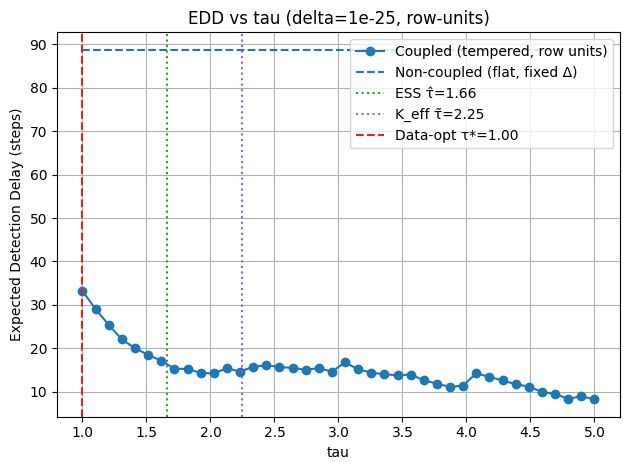

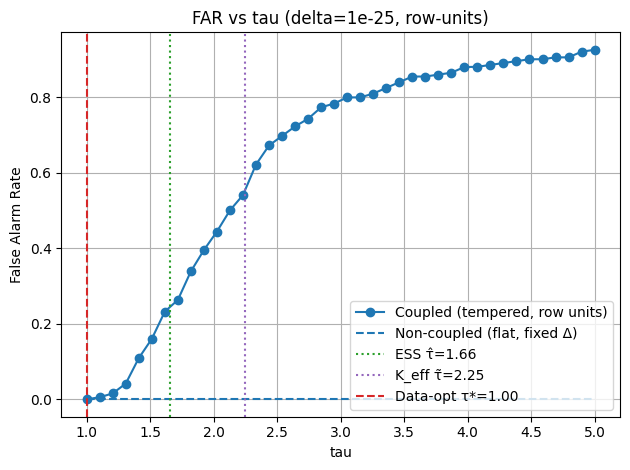

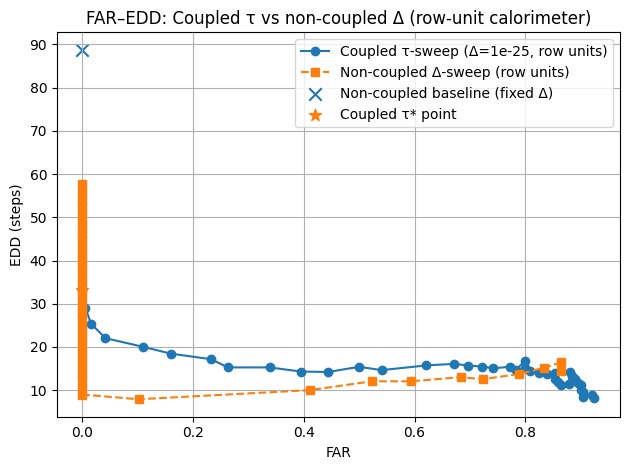

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

# ============================================================
# 0. Configure calorimeter so whole rows are "units"
# ============================================================
# Each block is 1 x 5 (a row), and only blocks go faulty (no indiv cells).
config_pre = Configuration(
    x_size=10,
    y_size=10,
    # leave cluster parameters at defaults
    p_cell_hot=0.0,
    p_cell_cold=0.0,
    block_size_x=2,
    block_size_y=10,
    p_cell_block_hot=0.01,
    p_cell_block_cold=0.01,
)

# Post-change: make row-block faults much more likely (stronger coupling)
config_post = Configuration(
    x_size=5,
    y_size=5,
    p_cell_hot=0.0,
    p_cell_cold=0.0,
    block_size_x=1,
    block_size_y=5,
    p_cell_block_hot=config_pre.p_cell_block_hot * 5.0,
    p_cell_block_cold=config_pre.p_cell_block_cold * 5.0,
)

# ============================================================
# 1. Build a 5-unit panel Y_unit[u, t] from calorimeter rows
# ============================================================
def build_unit_panel(
    n_events,
    config_pre,
    config_post=None,
    t_change=None,
    mode="fault_any",
):
    """
    Simulate n_events from FakeCalorimeter and return a 0/1 *unit* panel Y_unit.

    Units = rows: u = 0,...,X-1, each row contains all Y cells.

    Parameters
    ----------
    n_events : int
        Number of events (T).
    config_pre : Configuration
        Config used before t_change.
    config_post : Configuration or None
        Config used after t_change (if None, no distributional change).
    t_change : int or None
        Time index in {0,...,T-1} where we switch to config_post.
    mode : {"fault_any", "hot_only", "cold_only"}
        How to define the binary indicator per cell and time.

    Returns
    -------
    Y_unit : (U, T) int array
        Binary panel at unit (row) level: U = x_size.
        Y_unit[u, t] = 1 iff any cell in row u is faulty at t.
    """
    cal = FakeCalorimeter(config=config_pre)
    X, Y = cal.X, cal.Y
    T = n_events

    is_hot  = np.zeros((T, X, Y), dtype=bool)
    is_cold = np.zeros((T, X, Y), dtype=bool)

    for t in range(T):
        if config_post is not None and t_change is not None and t >= t_change:
            cal.config = config_post

        cal.generate_data()

        for (ix, iy), _E in cal.hot_cells.items():
            is_hot[t, ix, iy] = True
        for (ix, iy), _E in cal.cold_cells.items():
            is_cold[t, ix, iy] = True

    if mode == "fault_any":
        indicator = np.logical_or(is_hot, is_cold)  # (T, X, Y)
    elif mode == "hot_only":
        indicator = is_hot
    elif mode == "cold_only":
        indicator = is_cold
    else:
        raise ValueError(f"Unknown mode={mode!r}")

    # Aggregate to row-units: any faulty cell in row u at event t
    row_fault = indicator.any(axis=2)   # (T, X)
    Y_unit = row_fault.T.astype(int)    # (X, T) = (U, T)

    return Y_unit   # unit-level panel


# ============================================================
# 2. Amax computation + invariants for coupling
# ============================================================
def log_beta_vec(a, b):
    return gammaln(a) + gammaln(b) - gammaln(a + b)

def Amax_all_t(prefix_row, alpha, beta):
    """
    Compute Amax[t] for t=1..T for ONE series.
    Returns array A of shape (T+1,), 1-based in t, A[1] = -inf (no split).
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # L(1,t) for all t
    m_1t   = prefix_row[1:] - prefix_row[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t   = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)

    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # L(1, s-1)
        m_1_sm1   = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1   = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)

        # L(s, t)
        m_s_t   = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t   = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)

        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)

    return A

def precompute_tau_invariants(Y_panel, alpha, beta, pi, rho_shrink, t0, clip_neg_bf=True):
    """
    For a given panel Y_panel (U x T), precompute:

      - A_vals[t,u]: per-unit log-evidence (Amax)
      - logGM_excl[t,u]: leave-one-out log-geomean base
      - logs: (log1mp, logp) for mixing with prior pi
      - u_pre: log X_u(t) for t<=t0, used for tau estimation

    Shapes:
      Y_panel: (U, T)
      A_vals: (T+1, U)
      logGM_excl: (T+1, U)
      u_pre: (Tpre, U)
    """
    U, Tlen = Y_panel.shape
    prefix = np.zeros((U, Tlen + 1), dtype=int)
    for u in range(U):
        prefix[u, 1:] = np.cumsum(Y_panel[u, :])

    A_vals = np.full((Tlen + 1, U), -np.inf, dtype=float)
    for u in range(U):
        A_vals[:, u] = Amax_all_t(prefix_row=prefix[u], alpha=alpha, beta=beta)

    log1mp, logp = np.log(1 - pi), np.log(pi)

    logGM_excl = np.full((Tlen + 1, U), -np.inf, dtype=float)
    u_all = np.full((Tlen + 1, U), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)

        # logX = log((1-ρ) + ρ * BF)
        logX = np.logaddexp(np.log1p(-rho_shrink), np.log(rho_shrink) + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (U - 1)

    t0_eff = min(t0, Tlen)
    u_pre = u_all[2:t0_eff+1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre


# ============================================================
# 3. Tau estimators: ESS and K_eff
# ============================================================
def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_u u_u(t)).
    """
    if u_pre.size == 0:
        return 0.0
    var_u = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_u))
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    U = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, U - 1.0))
    return n_eff

def estimate_tau_keff_from_corr(u_pre):
    """
    K_eff-based tau: K_eff = (U-1) / (1 + (U-2)*rho_bar),
    where rho_bar is the mean pairwise correlation of Z_u(t)=log X_u(t).
    Returns (tau_keff, rho_bar).
    """
    if u_pre.size == 0:
        return 0.0, np.nan
    T_pre, U = u_pre.shape

    C = np.corrcoef(u_pre, rowvar=False)  # U x U
    off_diag = C[np.triu_indices(U, k=1)]
    mask = ~np.isnan(off_diag)
    if not np.any(mask):
        return 0.0, np.nan

    rho_bar = float(np.mean(off_diag[mask]))
    tau_keff = (U - 1.0) / (1.0 + (U - 2.0) * rho_bar)
    tau_keff = max(0.0, min(tau_keff, U - 1.0))
    return tau_keff, rho_bar


# ============================================================
# 4. Coupled & non-coupled alarm functions
# ============================================================
def first_alarm_from_scores(S, h=0.0):
    """
    S: (T+1, U) matrix of scores.
    Returns first t where ANY unit triggers S[t, u] >= h.
    """
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan

def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau, h=0.0):
    """
    For fixed tau, build logLambda and return (t_alarm_coupled, t_alarm_noncoupled)
    at the unit level.

    A_vals: (T+1, U) log-evidence
    logGM_excl: (T+1, U) leave-one-out log-geomean
    logs: (log1mp, logp) prior odds for group.
    """
    log1mp, logp = logs
    Tlen, U = A_vals.shape[0]-1, A_vals.shape[1]

    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c, h=h), first_alarm_from_scores(S_n, h=h)

def alarm_noncoupled_delta(A_vals, delta, h=0.0):
    """
    Pure non-coupled detector with arbitrary delta (unit level).
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n, h=h)


# ============================================================
# 5. Monte Carlo experiment: row-units, coupled vs non-coupled
# ============================================================
T     = 200     # events per run
t0    = 100     # true change time (switch pre -> post config)
R     = 200     # Monte Carlo runs

alpha = 1.0
beta  = 1.0
pi    = 1/1000
rho_shrink = 0.8
h     = 0.0

delta_fixed = 1e-25          # base delta for coupled vs fixed non-coupled
U = config_pre.x_size       # number of units = rows = 5
tau_grid = np.linspace(1, 5, 40)   # tau in [0, 4]

# delta grid for plain non-coupled delta-sweep (sensible range)
delta_grid = np.logspace(-20, -10, 40)

CLIP_NEG_BF = False

# --- precompute invariants and tau estimates for each run ---
precomp_list = []
tau_ess_runs  = []
tau_keff_runs = []
rho_bar_runs  = []

for r in range(R):
    Y_unit = build_unit_panel(
        n_events=T,
        config_pre=config_pre,
        config_post=config_post,
        t_change=t0,
        mode="fault_any",
    )
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants(
        Y_unit,
        alpha=alpha,
        beta=beta,
        pi=pi,
        rho_shrink=rho_shrink,
        t0=t0,
        clip_neg_bf=CLIP_NEG_BF,
    )
    tau_ess  = estimate_tau_ess_from_u(u_pre)
    tau_keff, rho_bar = estimate_tau_keff_from_corr(u_pre)

    tau_ess_runs.append(tau_ess)
    tau_keff_runs.append(tau_keff)
    rho_bar_runs.append(rho_bar)
    precomp_list.append((A_vals, logGM_excl, logs))

tau_hat_ESS  = float(np.median(tau_ess_runs))
tau_hat_KEFF = float(np.median(tau_keff_runs))
rho_bar_med  = float(np.nanmedian(rho_bar_runs))

print(f"Estimated tau (ESS, median over runs):   {tau_hat_ESS:.3f}")
print(f"Estimated tau (K_eff, median over runs): {tau_hat_KEFF:.3f}")
print(f"Median rho_bar (log X over units):       {rho_bar_med:.4f}")

# --- sweep tau at fixed delta: coupled vs fixed-delta non-coupled ---
rows = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau, h=h)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd  = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results = pd.DataFrame(rows)

# --- robust tau* selection ---
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")
far_baseline = results.loc[mask_n_fixed, "FAR"].iloc[0]

coupled_df = results[results["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled_df[coupled_df["FAR"] <= far_baseline + tol]

idx_best = None
if not feasible.empty:
    valid = feasible["EDD"].notna()
    if valid.any():
        idx_best = feasible.loc[valid, "EDD"].idxmin()
        tau_star = float(feasible.loc[idx_best, "tau"])
        edd_star = float(feasible.loc[idx_best, "EDD"])
    else:
        tau_star = np.nan
        edd_star = np.nan
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star}  (EDD={edd_star})")

# --- delta-sweep for NON-COUPLED detector (unit level) ---
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h=h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)
    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]

    if at.size > 0:
        far = float(np.mean(at < t0))
        dd  = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size if at.size > 0 else 0),
    })

results_delta = pd.DataFrame(rows_delta)
results_all = pd.concat([results, results_delta], ignore_index=True)

# ============================================================
# 6. Plots: EDD vs tau and FAR vs tau
# ============================================================
mask_c = (results["detector"] == "coupled_tempered")
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered, row units)")
plt.hlines(y=results.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS,  color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, color="tab:purple", linestyle=":",
            label=f"K_eff τ̃={tau_hat_KEFF:.2f}")
if (idx_best is not None) and np.isfinite(tau_star):
    row_star = coupled_df.loc[idx_best]
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (delta={delta_fixed}, row-units)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered, row units)")
plt.hlines(y=results.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS,  color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, color="tab:purple", linestyle=":",
            label=f"K_eff τ̃={tau_hat_KEFF:.2f}")
if (idx_best is not None) and np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (delta={delta_fixed}, row-units)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# 7. FAR–EDD parametric curve: coupled τ vs non-coupled Δ
# ============================================================
mask_c_all   = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g}, row units)")
plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep (row units)")

# Mark non-coupled baseline
plt.scatter(results.loc[mask_n_fixed, "FAR"].iloc[0],
            results.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# Mark τ* if available
if (idx_best is not None) and np.isfinite(tau_star):
    row_star = coupled_df.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD: Coupled τ vs non-coupled Δ (row-unit calorimeter)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


E_unit shape: (5, 300)
Row 0 mean energy pre-change:  140.588
Row 0 mean energy post-change: 131.790
Row 0 sd   energy pre-change:  72.596
Row 0 sd   energy post-change: 72.974


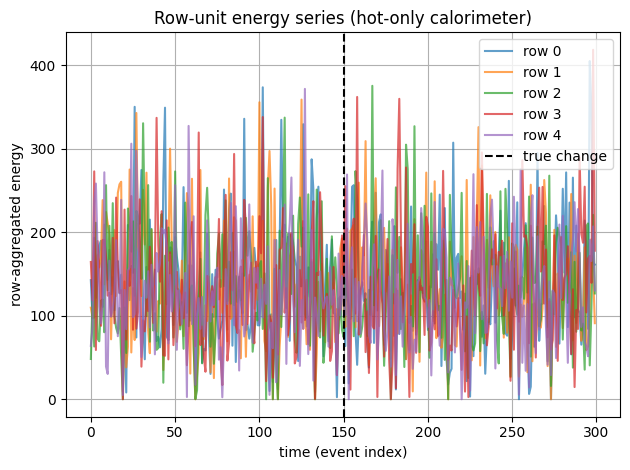

In [55]:
import numpy as np

# ============================================================
# 0. Configure calorimeter: only HOT faults, no COLD
# ============================================================
# We keep the original cluster/firing mechanics, but:
# - p_cell_cold       = 0
# - p_cell_block_cold = 0
# so cells can only become hot (wrong high-energy) but not cold (zero).
config_pre_hot = Configuration(
    x_size=5,
    y_size=5,
    max_number_of_clusters=50,
    max_cells_per_cluster=5,
    p_cell_hot=0.0005,          # baseline hot-cell prob (tweak as needed)
    p_cell_hot_fires=0.05,      # how often hot cells fire
    p_cell_cold=0.0,
    p_cell_cold_fires=0.0,
    block_size_x=1,             # 1x5 rows as blocks (rows as "units")
    block_size_y=5,
    p_cell_block_hot=0.002,     # baseline row-block hot prob
    p_cell_block_cold=0.0,
)

# Post-change: increase probabilities of HOT cells / HOT blocks
config_post_hot = Configuration(
    x_size=5,
    y_size=5,
    max_number_of_clusters=config_pre_hot.max_number_of_clusters,
    max_cells_per_cluster=config_pre_hot.max_cells_per_cluster,
    # individual hot cells more likely
    p_cell_hot=config_pre_hot.p_cell_hot * 5.0,
    p_cell_hot_fires=config_pre_hot.p_cell_hot_fires,
    # still no cold faults
    p_cell_cold=0.0,
    p_cell_cold_fires=0.0,
    # same block structure, larger hot-block probability
    block_size_x=1,
    block_size_y=5,
    p_cell_block_hot=config_pre_hot.p_cell_block_hot * 5.0,
    p_cell_block_cold=0.0,
)

# ============================================================
# 1. Build row-unit **energy** panel E_unit[u, t]
# ============================================================
def build_energy_unit_panel(
    n_events: int,
    config_pre: Configuration,
    config_post: Configuration | None = None,
    t_change: int | None = None,
    agg: str = "mean",
):
    """
    Simulate n_events from FakeCalorimeter and return a continuous
    energy panel E_unit[u, t] at the row-unit level.

    Units = rows: u = 0,...,X-1, each row contains Y cells.

    Parameters
    ----------
    n_events : int
        Number of events T.
    config_pre : Configuration
        Config used before t_change.
    config_post : Configuration or None
        Config used after t_change (if None, no distributional change).
    t_change : int or None
        If not None and config_post is given, switch to config_post at t_change.
    agg : {"mean", "sum", "max"}
        How to aggregate cell energies in a row to a unit-level scalar.

    Returns
    -------
    E_unit : (U, T) np.ndarray
        Continuous energy panel per row-unit and time.
    """
    cal = FakeCalorimeter(config=config_pre)
    X, Y = cal.X, cal.Y
    T = n_events

    # storage: (T, X, Y) raw energies
    energy_cube = np.zeros((T, X, Y), dtype=np.float32)

    for t in range(T):
        if config_post is not None and t_change is not None and t >= t_change:
            cal.config = config_post

        cal.generate_data()
        energy_cube[t] = cal.cell_energy  # shape (X, Y)

    # aggregate across columns (Y) to get row-level energy
    # energy_cube[t, ix, iy] -> row_energy[t, ix]
    if agg == "mean":
        row_energy = energy_cube.mean(axis=2)   # (T, X)
    elif agg == "sum":
        row_energy = energy_cube.sum(axis=2)    # (T, X)
    elif agg == "max":
        row_energy = energy_cube.max(axis=2)    # (T, X)
    else:
        raise ValueError(f"Unknown agg={agg!r}. Use 'mean', 'sum', or 'max'.")

    # transpose to (U, T) = (X, T)
    E_unit = row_energy.T  # shape (U, T)

    return E_unit, energy_cube  # second is optional raw energies if you want them


# ============================================================
# 2. Example: generate data and inspect baseline vs post-change
# ============================================================
T = 300
t0 = 150  # true change time where we switch config

E_unit, energy_cube = build_energy_unit_panel(
    n_events=T,
    config_pre=config_pre_hot,
    config_post=config_post_hot,
    t_change=t0,
    agg="mean",        # row-mean energy as unit observation
)

U = E_unit.shape[0]
print("E_unit shape:", E_unit.shape)  # (U=5, T=300)

# Quick sanity check: look at one row's energies pre vs post change
u0 = 0
pre_vals  = E_unit[u0, :t0]
post_vals = E_unit[u0, t0:]

print(f"Row {u0} mean energy pre-change:  {pre_vals.mean():.3f}")
print(f"Row {u0} mean energy post-change: {post_vals.mean():.3f}")
print(f"Row {u0} sd   energy pre-change:  {pre_vals.std(ddof=1):.3f}")
print(f"Row {u0} sd   energy post-change: {post_vals.std(ddof=1):.3f}")

# (Optional) simple plot to eyeball the shift in one unit
import matplotlib.pyplot as plt

plt.figure()
for u in range(U):
    plt.plot(E_unit[u], alpha=0.7, label=f"row {u}")
plt.axvline(t0, color="k", linestyle="--", label="true change")
plt.xlabel("time (event index)")
plt.ylabel("row-aggregated energy")
plt.title("Row-unit energy series (hot-only calorimeter)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Estimated tau (ESS, median over runs):   3.570
Estimated tau (K_eff, median over runs): 2.983
Median rho_bar (log X over units):       0.1137
Data-optimal tau at FAR<=baseline: 0.0  (EDD=105.0)


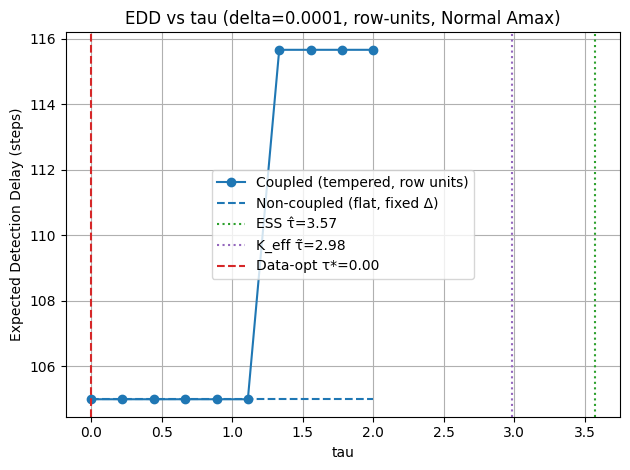

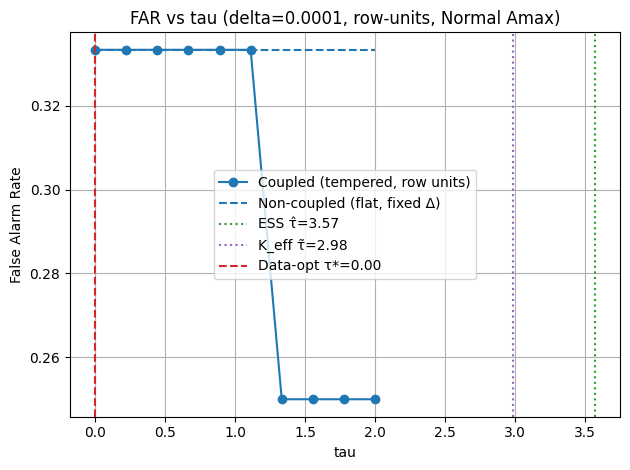

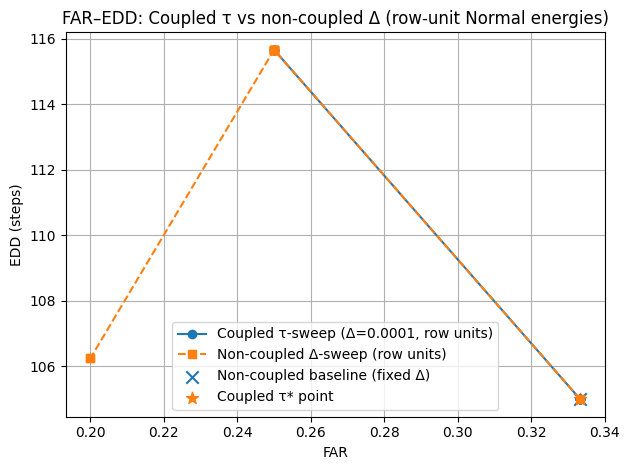

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

# ============================================================
# 0. Configure calorimeter: HOT-only row-block faults
# ============================================================
# Each block is 1x5 (a row), and only HOT faults (no cold).
config_pre_hot = Configuration(
    x_size=5,
    y_size=5,
    max_number_of_clusters=50,
    max_cells_per_cluster=5,
    p_cell_hot=0.0005,          # baseline hot cell prob
    p_cell_hot_fires=0.05,      # how often hot cells fire
    p_cell_cold=0.0,            # no cold cells
    p_cell_cold_fires=0.0,
    block_size_x=1,             # 1x5 rows as blocks
    block_size_y=5,
    p_cell_block_hot=0.002,     # baseline row-block hot prob
    p_cell_block_cold=0.0,      # no cold blocks
)

# Post-change: increase HOT cell/block probabilities
config_post_hot = Configuration(
    x_size=5,
    y_size=5,
    max_number_of_clusters=config_pre_hot.max_number_of_clusters,
    max_cells_per_cluster=config_pre_hot.max_cells_per_cluster,
    p_cell_hot=config_pre_hot.p_cell_hot * 5.0,
    p_cell_hot_fires=config_pre_hot.p_cell_hot_fires,
    p_cell_cold=0.0,
    p_cell_cold_fires=0.0,
    block_size_x=1,
    block_size_y=5,
    p_cell_block_hot=config_pre_hot.p_cell_block_hot * 5.0,
    p_cell_block_cold=0.0,
)

# ============================================================
# 1. Build row-unit energy panel E_unit[u, t]
# ============================================================
def build_energy_unit_panel(
    n_events: int,
    config_pre: Configuration,
    config_post: Configuration | None = None,
    t_change: int | None = None,
    agg: str = "mean",
):
    """
    Simulate n_events from FakeCalorimeter and return a continuous
    energy panel E_unit[u, t] at the row-unit level.

    Units = rows: u = 0,...,X-1, each row contains Y cells.

    Returns
    -------
    E_unit : (U, T) np.ndarray
        Continuous energy panel per row-unit and time.
    energy_cube : (T, X, Y) np.ndarray
        Raw cell energies for optional inspection.
    """
    cal = FakeCalorimeter(config=config_pre)
    X, Y = cal.X, cal.Y
    T = n_events

    energy_cube = np.zeros((T, X, Y), dtype=np.float32)

    for t in range(T):
        if config_post is not None and t_change is not None and t >= t_change:
            cal.config = config_post
        cal.generate_data()
        energy_cube[t] = cal.cell_energy

    if agg == "mean":
        row_energy = energy_cube.mean(axis=2)   # (T, X)
    elif agg == "sum":
        row_energy = energy_cube.sum(axis=2)    # (T, X)
    elif agg == "max":
        row_energy = energy_cube.max(axis=2)    # (T, X)
    else:
        raise ValueError(f"Unknown agg={agg!r}. Use 'mean', 'sum', or 'max'.")

    E_unit = row_energy.T  # (U, T) = (X, T)
    return E_unit, energy_cube


# ============================================================
# 2. Normal-mean Amax for continuous series
# ============================================================
# We treat standardized E_unit[u,t] as Normal(μ, 1), and use
# a generalized log-likelihood ratio for a mean change.

def seg_stats(prefix_sum, prefix_sumsq, a, b):
    """
    Segment stats for indices a..b (1-based inclusive).
    prefix_sum[k] = ∑_{i=1}^k y_i
    prefix_sumsq[k] = ∑_{i=1}^k y_i^2
    """
    s = prefix_sum[b] - prefix_sum[a-1]
    sq = prefix_sumsq[b] - prefix_sumsq[a-1]
    n = b - a + 1
    # sum of squared residuals around segment mean
    ssr = sq - s**2 / n
    return n, s, ssr

def Amax_all_t_normal(prefix_sum, prefix_sumsq):
    """
    Compute normal-mean GLR-style Amax[t] for t=1..T.
    Data are assumed standardized so σ^2=1.
    A[t] = 0.5 * max_s (SSR_all - (SSR1 + SSR2)) for s=2..t.

    Returns array A of shape (T+1,), 1-based; A[1] = -inf.
    """
    Tlen = prefix_sum.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        # SSR for full segment 1..t
        _, _, ssr_all = seg_stats(prefix_sum, prefix_sumsq, 1, t)
        best = 0.0
        for s in range(2, t + 1):
            # split at s: (1..s-1) and (s..t)
            _, _, ssr_1 = seg_stats(prefix_sum, prefix_sumsq, 1, s-1)
            _, _, ssr_2 = seg_stats(prefix_sum, prefix_sumsq, s, t)
            delta_ssr = ssr_all - (ssr_1 + ssr_2)
            if delta_ssr > best:
                best = delta_ssr
        A[t] = 0.5 * best  # σ^2 = 1 after standardization
    return A

def precompute_tau_invariants_normal(E_unit_std, pi, rho_shrink, t0, clip_neg_bf=True):
    """
    For a given standardized panel E_unit_std (U x T), precompute:

      - A_vals[t,u]: per-unit log-evidence (Amax under normal mean change)
      - logGM_excl[t,u]: leave-one-out log-geomean base
      - logs: (log1mp, logp) for mixing with prior pi
      - u_pre: log X_u(t) for t<=t0, used for tau estimation
    """
    U, Tlen = E_unit_std.shape
    # cumulative sums
    prefix_sum   = np.zeros((U, Tlen + 1), dtype=float)
    prefix_sumsq = np.zeros((U, Tlen + 1), dtype=float)
    for u in range(U):
        prefix_sum[u, 1:]   = np.cumsum(E_unit_std[u, :])
        prefix_sumsq[u, 1:] = np.cumsum(E_unit_std[u, :]**2)

    A_vals = np.full((Tlen + 1, U), -np.inf, dtype=float)
    for u in range(U):
        A_vals[:, u] = Amax_all_t_normal(prefix_sum[u], prefix_sumsq[u])
    # numerical safety
    A_vals[2:, :] = np.maximum(A_vals[2:, :], 0.0)

    log1mp, logp = np.log(1 - pi), np.log(pi)

    logGM_excl = np.full((Tlen + 1, U), -np.inf, dtype=float)
    u_all = np.full((Tlen + 1, U), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF)
        logX = np.logaddexp(np.log1p(-rho_shrink), np.log(rho_shrink) + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (U - 1)

    t0_eff = min(t0, Tlen)
    u_pre = u_all[2:t0_eff+1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre


# ============================================================
# 3. Tau estimators: ESS and K_eff (on log X)
# ============================================================
def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_u u_u(t)).
    """
    if u_pre.size == 0:
        return 0.0
    var_u = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_u))
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    U = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, U - 1.0))
    return n_eff

def estimate_tau_keff_from_corr(u_pre):
    """
    K_eff-based tau: K_eff = (U-1) / (1 + (U-2)*rho_bar),
    where rho_bar is the mean pairwise correlation of Z_u(t)=log X_u(t).
    Returns (tau_keff, rho_bar).
    """
    if u_pre.size == 0:
        return 0.0, np.nan
    T_pre, U = u_pre.shape

    C = np.corrcoef(u_pre, rowvar=False)  # U x U
    off_diag = C[np.triu_indices(U, k=1)]
    mask = ~np.isnan(off_diag)
    if not np.any(mask):
        return 0.0, np.nan

    rho_bar = float(np.mean(off_diag[mask]))
    tau_keff = (U - 1.0) / (1.0 + (U - 2.0) * rho_bar)
    tau_keff = max(0.0, min(tau_keff, U - 1.0))
    return tau_keff, rho_bar


# ============================================================
# 4. Coupled & non-coupled alarm functions (same as before)
# ============================================================
def first_alarm_from_scores(S, h=0.0):
    """
    S: (T+1, U) matrix of scores.
    Returns first t where ANY unit triggers S[t, u] >= h.
    """
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan

def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau, h=0.0):
    """
    For fixed tau, build logLambda and return (t_alarm_coupled, t_alarm_noncoupled)
    at the unit level.

    A_vals: (T+1, U) log-evidence
    logGM_excl: (T+1, U) leave-one-out log-geomean
    logs: (log1mp, logp) prior odds for group.
    """
    log1mp, logp = logs
    Tlen, U = A_vals.shape[0]-1, A_vals.shape[1]

    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c, h=h), first_alarm_from_scores(S_n, h=h)

def alarm_noncoupled_delta(A_vals, delta, h=0.0):
    """
    Pure non-coupled detector with arbitrary delta (unit level).
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n, h=h)


# ============================================================
# 5. Monte Carlo experiment: row-units, coupled vs non-coupled
# ============================================================
T     = 300     # events per run
t0    = 150     # true change time (switch pre -> post config)
R     = 200     # Monte Carlo runs

pi    = 1/100
rho_shrink = 0.8
h     = 0.0
rng = np.random.default_rng(31415)
delta_fixed = 1e-4         # base delta for coupled vs fixed non-coupled
U = config_pre_hot.x_size   # number of units = rows = 5
tau_grid = np.linspace(0.0, 2, 10)   # tau in [0, 4]

# delta grid for plain non-coupled delta-sweep (sensible range)
delta_grid = np.linspace(1e-4, 1e-3, 10)

CLIP_NEG_BF = True

# --- precompute invariants and tau estimates for each run ---
precomp_list = []
tau_ess_runs  = []
tau_keff_runs = []
rho_bar_runs  = []

for r in range(R):
    # build energy panel
    E_unit, _ = build_energy_unit_panel(
        n_events=T,
        config_pre=config_pre_hot,
        config_post=config_post_hot,
        t_change=t0,
        agg="mean",
    )
    # standardize using pre-change window across all units
    pre_slice = E_unit[:, :t0].ravel()
    mu_pre = np.mean(pre_slice)
    sd_pre = np.std(pre_slice, ddof=1)
    if sd_pre <= 0:
        E_unit_std = E_unit - mu_pre
    else:
        E_unit_std = (E_unit - mu_pre) / sd_pre

    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants_normal(
        E_unit_std,
        pi=pi,
        rho_shrink=rho_shrink,
        t0=t0,
        clip_neg_bf=CLIP_NEG_BF,
    )
    tau_ess  = estimate_tau_ess_from_u(u_pre)
    tau_keff, rho_bar = estimate_tau_keff_from_corr(u_pre)

    tau_ess_runs.append(tau_ess)
    tau_keff_runs.append(tau_keff)
    rho_bar_runs.append(rho_bar)
    precomp_list.append((A_vals, logGM_excl, logs))

tau_hat_ESS  = float(np.median(tau_ess_runs))
tau_hat_KEFF = float(np.median(tau_keff_runs))
rho_bar_med  = float(np.nanmedian(rho_bar_runs))

print(f"Estimated tau (ESS, median over runs):   {tau_hat_ESS:.3f}")
print(f"Estimated tau (K_eff, median over runs): {tau_hat_KEFF:.3f}")
print(f"Median rho_bar (log X over units):       {rho_bar_med:.4f}")

# --- sweep tau at fixed delta: coupled vs fixed-delta non-coupled ---
rows = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau, h=h)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd  = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results = pd.DataFrame(rows)

# --- robust tau* selection ---
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")
far_baseline = results.loc[mask_n_fixed, "FAR"].iloc[0]

coupled_df = results[results["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled_df[coupled_df["FAR"] <= far_baseline + tol]

idx_best = None
if not feasible.empty:
    valid = feasible["EDD"].notna()
    if valid.any():
        idx_best = feasible.loc[valid, "EDD"].idxmin()
        tau_star = float(feasible.loc[idx_best, "tau"])
        edd_star = float(feasible.loc[idx_best, "EDD"])
    else:
        tau_star = np.nan
        edd_star = np.nan
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star}  (EDD={edd_star})")

# --- delta-sweep for NON-COUPLED detector (unit level) ---
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h=h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)
    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]

    if at.size > 0:
        far = float(np.mean(at < t0))
        dd  = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size if at.size > 0 else 0),
    })

results_delta = pd.DataFrame(rows_delta)
results_all = pd.concat([results, results_delta], ignore_index=True)

# ============================================================
# 6. Plots: EDD vs tau and FAR vs tau (coupled vs non-coupled)
# ============================================================
mask_c = (results["detector"] == "coupled_tempered")
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered, row units)")
plt.hlines(y=results.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS,  color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, color="tab:purple", linestyle=":",
            label=f"K_eff τ̃={tau_hat_KEFF:.2f}")
if (idx_best is not None) and np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (delta={delta_fixed}, row-units, Normal Amax)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered, row units)")
plt.hlines(y=results.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS,  color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, color="tab:purple", linestyle=":",
            label=f"K_eff τ̃={tau_hat_KEFF:.2f}")
if (idx_best is not None) and np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (delta={delta_fixed}, row-units, Normal Amax)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


mask_c_all   = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g}, row units)")
plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep (row units)")


plt.scatter(results.loc[mask_n_fixed, "FAR"].iloc[0],
            results.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")


if (idx_best is not None) and np.isfinite(tau_star):
    row_star = coupled_df.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD: Coupled τ vs non-coupled Δ (row-unit Normal energies)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Estimated tau (ESS, median over runs):   3.573
Estimated tau (K_eff, median over runs): 3.007
Median rho_bar (log X over units):       0.1101
Data-optimal tau at FAR<=baseline: 4.23076923076923  (EDD=58.666666666666664)


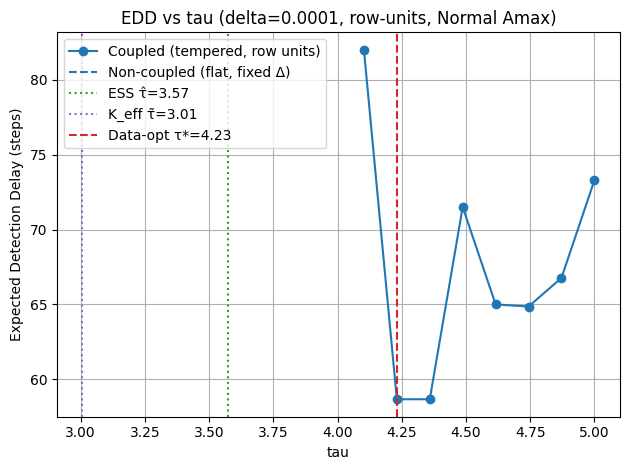

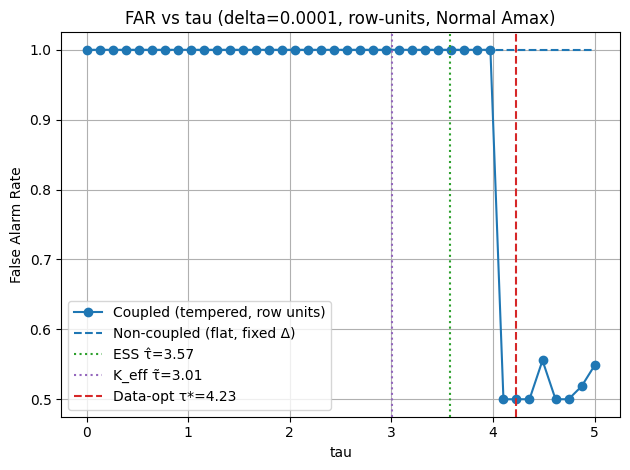

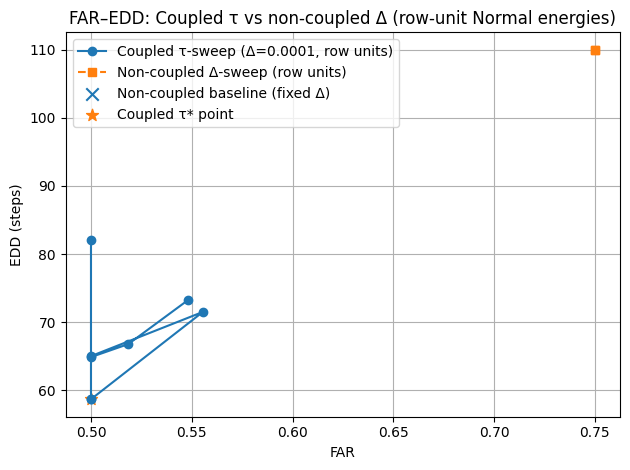

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# 0. Global seeding for reproducibility
# ============================================================
MASTER_SEED = 12345
master_rng = np.random.default_rng(MASTER_SEED)
np.random.seed(MASTER_SEED)  # belt-and-braces if legacy RNG is used anywhere

# ============================================================
# 1. Configure calorimeter: HOT-only row-block faults
# ============================================================
# Each block is 1x5 (a row), and only HOT faults (no cold).
config_pre_hot = Configuration(
    x_size=5,
    y_size=5,
    max_number_of_clusters=50,
    max_cells_per_cluster=5,
    p_cell_hot=0.0005,          # baseline hot cell prob
    p_cell_hot_fires=0.05,      # how often hot cells fire
    p_cell_cold=0.0,            # no cold cells
    p_cell_cold_fires=0.0,
    block_size_x=1,             # 1x5 rows as blocks
    block_size_y=5,
    p_cell_block_hot=0.002,     # baseline row-block hot prob
    p_cell_block_cold=0.0,      # no cold blocks
)

# Post-change: increase HOT cell/block probabilities
config_post_hot = Configuration(
    x_size=5,
    y_size=5,
    max_number_of_clusters=config_pre_hot.max_number_of_clusters,
    max_cells_per_cluster=config_pre_hot.max_cells_per_cluster,
    p_cell_hot=config_pre_hot.p_cell_hot * 5.0,
    p_cell_hot_fires=config_pre_hot.p_cell_hot_fires,
    p_cell_cold=0.0,
    p_cell_cold_fires=0.0,
    block_size_x=1,
    block_size_y=5,
    p_cell_block_hot=config_pre_hot.p_cell_block_hot * 5.0,
    p_cell_block_cold=0.0,
)

# ============================================================
# 2. Build row-unit energy panel E_unit[u, t] with fixed seed
# ============================================================
def build_energy_unit_panel(
    n_events: int,
    config_pre: Configuration,
    config_post: Configuration | None = None,
    t_change: int | None = None,
    agg: str = "mean",
    rng_seed: int | None = None,
):
    """
    Simulate n_events from FakeCalorimeter and return a continuous
    energy panel E_unit[u, t] at the row-unit level.

    Units = rows: u = 0,...,X-1, each row contains Y cells.

    If rng_seed is provided, the internal calorimeter RNG is fixed
    so that this function is deterministic for that seed.
    """
    cal = FakeCalorimeter(config=config_pre)
    if rng_seed is not None:
        cal._rng = np.random.default_rng(rng_seed)

    X, Y = cal.X, cal.Y
    T = n_events

    energy_cube = np.zeros((T, X, Y), dtype=np.float32)

    for t in range(T):
        if config_post is not None and t_change is not None and t >= t_change:
            cal.config = config_post
        cal.generate_data()
        energy_cube[t] = cal.cell_energy

    if agg == "mean":
        row_energy = energy_cube.mean(axis=2)   # (T, X)
    elif agg == "sum":
        row_energy = energy_cube.sum(axis=2)    # (T, X)
    elif agg == "max":
        row_energy = energy_cube.max(axis=2)    # (T, X)
    else:
        raise ValueError(f"Unknown agg={agg!r}. Use 'mean', 'sum', or 'max'.")

    E_unit = row_energy.T  # (U, T) = (X, T)
    return E_unit, energy_cube


# ============================================================
# 3. Normal-mean Amax for continuous series
# ============================================================
def seg_stats(prefix_sum, prefix_sumsq, a, b):
    """
    Segment stats for indices a..b (1-based inclusive).
    prefix_sum[k] = ∑_{i=1}^k y_i
    prefix_sumsq[k] = ∑_{i=1}^k y_i^2
    """
    s  = prefix_sum[b]   - prefix_sum[a-1]
    sq = prefix_sumsq[b] - prefix_sumsq[a-1]
    n  = b - a + 1
    ssr = sq - s**2 / n   # sum of squared residuals around segment mean
    return n, s, ssr

def Amax_all_t_normal(prefix_sum, prefix_sumsq):
    """
    Compute normal-mean GLR-style Amax[t] for t=1..T.
    Data are assumed standardized so σ^2=1.
    A[t] = 0.5 * max_s (SSR_all - (SSR1 + SSR2)) for s=2..t.

    Returns array A of shape (T+1,), 1-based; A[1] = -inf.
    """
    Tlen = prefix_sum.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        _, _, ssr_all = seg_stats(prefix_sum, prefix_sumsq, 1, t)
        best = 0.0
        for s in range(2, t + 1):
            _, _, ssr_1 = seg_stats(prefix_sum, prefix_sumsq, 1, s-1)
            _, _, ssr_2 = seg_stats(prefix_sum, prefix_sumsq, s, t)
            delta_ssr = ssr_all - (ssr_1 + ssr_2)
            if delta_ssr > best:
                best = delta_ssr
        A[t] = 0.5 * best  # σ^2 = 1 after standardization
    return A

def precompute_tau_invariants_normal(E_unit_std, pi, rho_shrink, t0, clip_neg_bf=True):
    """
    For a standardized panel E_unit_std (U x T), precompute:

      - A_vals[t,u]: per-unit log-evidence (Amax under normal mean change)
      - logGM_excl[t,u]: leave-one-out log-geomean base
      - logs: (log1mp, logp) for mixing with prior pi
      - u_pre: log X_u(t) for t<=t0, used for tau estimation
    """
    U, Tlen = E_unit_std.shape
    prefix_sum   = np.zeros((U, Tlen + 1), dtype=float)
    prefix_sumsq = np.zeros((U, Tlen + 1), dtype=float)
    for u in range(U):
        prefix_sum[u, 1:]   = np.cumsum(E_unit_std[u, :])
        prefix_sumsq[u, 1:] = np.cumsum(E_unit_std[u, :]**2)

    A_vals = np.full((Tlen + 1, U), -np.inf, dtype=float)
    for u in range(U):
        A_vals[:, u] = Amax_all_t_normal(prefix_sum[u], prefix_sumsq[u])
    A_vals[2:, :] = np.maximum(A_vals[2:, :], 0.0)  # safety

    log1mp, logp = np.log(1 - pi), np.log(pi)

    logGM_excl = np.full((Tlen + 1, U), -np.inf, dtype=float)
    u_all      = np.full((Tlen + 1, U), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF)
        logX = np.logaddexp(np.log1p(-rho_shrink), np.log(rho_shrink) + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (U - 1)

    t0_eff = min(t0, Tlen)
    u_pre = u_all[2:t0_eff+1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre


# ============================================================
# 4. Tau estimators: ESS and K_eff (on log X)
# ============================================================
def estimate_tau_ess_from_u(u_pre):
    if u_pre.size == 0:
        return 0.0
    var_u = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_u))
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    U = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, U - 1.0))
    return n_eff

def estimate_tau_keff_from_corr(u_pre):
    if u_pre.size == 0:
        return 0.0, np.nan
    T_pre, U = u_pre.shape

    C = np.corrcoef(u_pre, rowvar=False)  # U x U
    off_diag = C[np.triu_indices(U, k=1)]
    mask = ~np.isnan(off_diag)
    if not np.any(mask):
        return 0.0, np.nan

    rho_bar = float(np.mean(off_diag[mask]))
    tau_keff = (U - 1.0) / (1.0 + (U - 2.0) * rho_bar)
    tau_keff = max(0.0, min(tau_keff, U - 1.0))
    return tau_keff, rho_bar


# ============================================================
# 5. Coupled & non-coupled alarm functions
# ============================================================
def first_alarm_from_scores(S, h=0.0):
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan

def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau, h=0.0):
    log1mp, logp = logs
    Tlen, U = A_vals.shape[0]-1, A_vals.shape[1]

    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c, h=h), first_alarm_from_scores(S_n, h=h)

def alarm_noncoupled_delta(A_vals, delta, h=0.0):
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n, h=h)


# ============================================================
# 6. Monte Carlo experiment: row-units, coupled vs non-coupled
# ============================================================
T     = 300     # events per run
t0    = 150     # true change time
R     = 200     # Monte Carlo runs

pi    = 1/1000
rho_shrink = 0.8
h     = 0.0

delta_fixed = 1e-4          # base delta for coupled vs fixed non-coupled
U = config_pre_hot.x_size   # number of units = rows = 5
tau_grid = np.linspace(0.0, 5, 40)

delta_grid = np.linspace(1e-4 , 1e-3, 40)
CLIP_NEG_BF = True

precomp_list = []
tau_ess_runs  = []
tau_keff_runs = []
rho_bar_runs  = []

for r in range(R):
    # derive deterministic seed for this run
    seed_r = int(master_rng.integers(0, 2**32 - 1))

    E_unit, _ = build_energy_unit_panel(
        n_events=T,
        config_pre=config_pre_hot,
        config_post=config_post_hot,
        t_change=t0,
        agg="mean",
        rng_seed=seed_r,
    )

    # standardize using pre-change window across all units
    pre_slice = E_unit[:, :t0].ravel()
    mu_pre = np.mean(pre_slice)
    sd_pre = np.std(pre_slice, ddof=1)
    if sd_pre <= 0:
        E_unit_std = E_unit - mu_pre
    else:
        E_unit_std = (E_unit - mu_pre) / sd_pre

    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants_normal(
        E_unit_std,
        pi=pi,
        rho_shrink=rho_shrink,
        t0=t0,
        clip_neg_bf=CLIP_NEG_BF,
    )
    tau_ess  = estimate_tau_ess_from_u(u_pre)
    tau_keff, rho_bar = estimate_tau_keff_from_corr(u_pre)

    tau_ess_runs.append(tau_ess)
    tau_keff_runs.append(tau_keff)
    rho_bar_runs.append(rho_bar)
    precomp_list.append((A_vals, logGM_excl, logs))

tau_hat_ESS  = float(np.median(tau_ess_runs))
tau_hat_KEFF = float(np.median(tau_keff_runs))
rho_bar_med  = float(np.nanmedian(rho_bar_runs))

print(f"Estimated tau (ESS, median over runs):   {tau_hat_ESS:.3f}")
print(f"Estimated tau (K_eff, median over runs): {tau_hat_KEFF:.3f}")
print(f"Median rho_bar (log X over units):       {rho_bar_med:.4f}")

# --- sweep tau at fixed delta: coupled vs fixed-delta non-coupled ---
rows = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau, h=h)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd  = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results = pd.DataFrame(rows)

# --- robust tau* selection ---
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")
far_baseline = results.loc[mask_n_fixed, "FAR"].iloc[0]

coupled_df = results[results["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled_df[coupled_df["FAR"] <= far_baseline + tol]

idx_best = None
if not feasible.empty:
    valid = feasible["EDD"].notna()
    if valid.any():
        idx_best = feasible.loc[valid, "EDD"].idxmin()
        tau_star = float(feasible.loc[idx_best, "tau"])
        edd_star = float(feasible.loc[idx_best, "EDD"])
    else:
        tau_star = np.nan
        edd_star = np.nan
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star}  (EDD={edd_star})")

# --- delta-sweep for NON-COUPLED detector ---
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h=h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)
    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]

    if at.size > 0:
        far = float(np.mean(at < t0))
        dd  = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size if at.size > 0 else 0),
    })

results_delta = pd.DataFrame(rows_delta)
results_all = pd.concat([results, results_delta], ignore_index=True)

# ============================================================
# 7. Plots: EDD vs tau and FAR vs tau
# ============================================================
mask_c = (results["detector"] == "coupled_tempered")
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered, row units)")
plt.hlines(y=results.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS,  color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, color="tab:purple", linestyle=":",
            label=f"K_eff τ̃={tau_hat_KEFF:.2f}")
if (idx_best is not None) and np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (delta={delta_fixed}, row-units, Normal Amax)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered, row units)")
plt.hlines(y=results.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS,  color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, color="tab:purple", linestyle=":",
            label=f"K_eff τ̃={tau_hat_KEFF:.2f}")
if (idx_best is not None) and np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (delta={delta_fixed}, row-units, Normal Amax)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# 8. FAR–EDD parametric curve: coupled τ vs non-coupled Δ
# ============================================================
mask_c_all   = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g}, row units)")
plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep (row units)")

plt.scatter(results.loc[mask_n_fixed, "FAR"].iloc[0],
            results.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

if (idx_best is not None) and np.isfinite(tau_star):
    row_star = coupled_df.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD: Coupled τ vs non-coupled Δ (row-unit Normal energies)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


True changepoint t0: 150
Detected alarm time: 159.0
Detection delay:    9.0 time steps


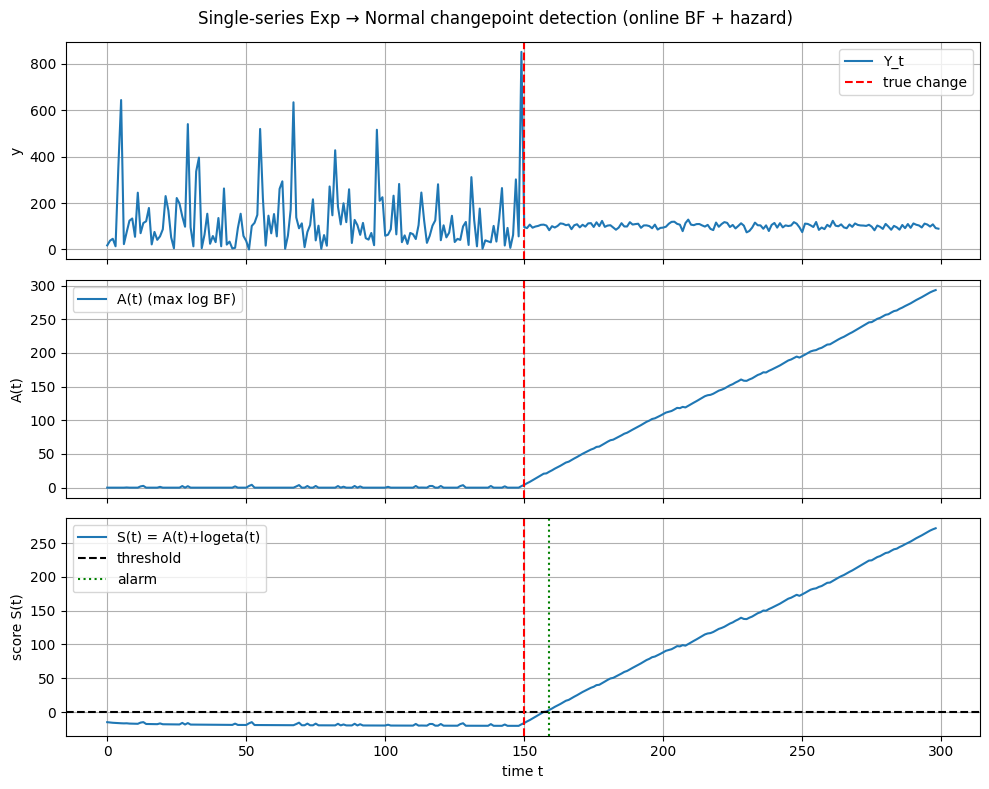


Monte Carlo summary (single series):
  FAR (delta=0.001): 0.000
  EDD (delta=0.001): 11.9 steps


In [68]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 0. Global RNG seed for reproducibility
# ==========================================
MASTER_SEED = 2025
rng_global = np.random.default_rng(MASTER_SEED)
np.random.seed(MASTER_SEED)  # if you ever use np.random.* legacy


# ==========================================
# 1. Data generator: single series Exp -> Normal
# ==========================================
def simulate_single_cell(T, t0, lam=1/150, hot_mean=None, sigma=10.0, rng=None):
    """
    Simulate a single series Y_t, t=0,...,T-1:

      - For t < t0:   Y_t ~ Exp(lam) with mean 1/lam; then scaled by 150 if lam=1/150
      - For t >= t0:  Y_t ~ Normal(hot_mean, sigma^2), truncated at 0

    hot_mean is drawn Uniform(0,150) if not provided, mimicking FakeCalorimeter.
    Returns:
        y        : np.ndarray of shape (T,)
        hot_mean : the hot mean used
    """
    if rng is None:
        rng = rng_global

    if hot_mean is None:
        hot_mean = rng.random() * 150.0  # Uniform(0,150)

    y = np.zeros(T)
    for t in range(T):
        if t < t0:
            # Exp with mean 1/lam; for lam=1/150 this is exactly Exp(1)*150
            y[t] = rng.exponential(1.0 / lam)
        else:
            e = rng.normal(hot_mean, sigma)
            y[t] = max(e, 0.0)  # truncate at 0
    return y, hot_mean


# ==========================================
# 2. Log-likelihoods for Exp and Normal
# ==========================================
def exp_loglik_segment(y, a, b, lam):
    """
    log-likelihood under Exp(lam) for y[a:b+1], 0-based indices inclusive.
    """
    seg = y[a:b+1]
    n = seg.size
    return n * np.log(lam) - lam * seg.sum()


def norm_loglik_segment(y, a, b, mu, sigma):
    """
    log-likelihood under N(mu, sigma^2) for y[a:b+1], ignoring truncation.
    """
    seg = y[a:b+1]
    n = seg.size
    return -0.5 * n * np.log(2 * np.pi * sigma**2) - 0.5 * ((seg - mu) ** 2).sum() / sigma**2


# ==========================================
# 3. Amax(t): Exp -> Normal log-BF field
# ==========================================
def Amax_exp_to_norm(y, lam, mu1, sigma):
    """
    Compute A[t] for t=1..T (1-based index) for single series y,
    where the one-change model is Exp(lam) -> N(mu1, sigma^2).

    Model comparison at time t:

      M0: all y[0:t] i.i.d. Exp(lam)
      M1(s): y[0:s-1] Exp(lam), y[s:t] Normal(mu1, sigma^2), s=1..t-1

    A[t] = max_s log BF(s,t) truncated at 0 (i.e. evidence for change at some s).

    Returns:
        A : np.ndarray of length T+1, with:
            A[0] = NaN,
            A[1] = -inf (no split possible),
            A[t] defined for t >= 2.
    """
    T = len(y)
    A = np.full(T + 1, -np.inf, dtype=float)
    A[0] = np.nan

    for t in range(1, T + 1):
        if t < 2:
            continue  # no split possible at t=1
        # No-change log likelihood on 0..t-1
        ell0 = exp_loglik_segment(y, 0, t - 1, lam)
        best = 0.0
        # splits s = 1..t-1 in 1-based -> 0..t-2 in 0-based
        for s in range(1, t):
            ell_exp_1 = exp_loglik_segment(y, 0, s - 1, lam)      # segment 1..s
            ell_norm_2 = norm_loglik_segment(y, s, t - 1, mu1, sigma)  # s+1..t
            logBF = ell_exp_1 + ell_norm_2 - ell0
            if logBF > best:
                best = logBF
        A[t] = max(0.0, best)
    return A


# ==========================================
# 4. Hazard spending & online alarm
# ==========================================
def hazard_logeta(delta, T):
    """
    Compute log hazard spending logeta[t] for t=0..T, 1-based effective:

        logeta[t] = log(delta^2) - (log(t+1) + log log(t+1)), for t>=1
        logeta[0] unused; logeta[1] = -inf (no hazard before t=2)

    Returns:
        logeta : np.ndarray of length T+1
    """
    t = np.arange(T + 1)
    logeta = np.full(T + 1, -np.inf, dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta[1:] = np.log(delta * delta) - (np.log(t[1:] + 1) + np.log(np.log(t[1:] + 1)))
    logeta[0] = np.nan
    logeta[1] = -np.inf  # no hazard at t=1 (no split)
    return logeta


def first_alarm(A, logeta, h=0.0):
    """
    Single-series online alarm:

        S[t] = A[t] + logeta[t]
        alarm at first t with S[t] >= h

    Returns:
        t_alarm : float index (1-based) or np.nan if no alarm.
    """
    S = A + logeta
    # indices t >= 2 only
    for t in range(2, len(S)):
        if S[t] >= h:
            return float(t)
    return np.nan


# ==========================================
# 5. One example run: simulate and detect
# ==========================================
if __name__ == "__main__":
    # --- Settings ---
    T = 300
    t0 = 150  # true changepoint
    lam = 1 / 150.0
    sigma_hot = 10.0
    delta = 1e-3
    h = 0.0

    # Simulate one series
    rng = np.random.default_rng(123)
    y, hot_mean = simulate_single_cell(T, t0, lam=lam, hot_mean=None, sigma=sigma_hot, rng=rng)

    # Build Amax field
    A = Amax_exp_to_norm(y, lam=lam, mu1=hot_mean, sigma=sigma_hot)

    # Hazard spending
    logeta = hazard_logeta(delta, T)

    # Find alarm time
    t_alarm = first_alarm(A, logeta, h=h)

    print(f"True changepoint t0: {t0}")
    print(f"Detected alarm time: {t_alarm}")
    if np.isfinite(t_alarm):
        print(f"Detection delay:    {t_alarm - t0:.1f} time steps")
    else:
        print("No alarm triggered.")

    # Optional: quick visualization
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

    axs[0].plot(y, label="Y_t")
    axs[0].axvline(t0, color="red", linestyle="--", label="true change")
    axs[0].set_ylabel("y")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(A[2:], label="A(t) (max log BF)")
    axs[1].axvline(t0, color="red", linestyle="--")
    axs[1].set_ylabel("A(t)")
    axs[1].legend()
    axs[1].grid(True)

    S = A + logeta
    axs[2].plot(S[2:], label="S(t) = A(t)+logeta(t)")
    axs[2].axhline(h, color="black", linestyle="--", label="threshold")
    axs[2].axvline(t0, color="red", linestyle="--")
    if np.isfinite(t_alarm):
        axs[2].axvline(t_alarm, color="green", linestyle=":", label="alarm")
    axs[2].set_xlabel("time t")
    axs[2].set_ylabel("score S(t)")
    axs[2].legend()
    axs[2].grid(True)

    fig.suptitle("Single-series Exp → Normal changepoint detection (online BF + hazard)")
    plt.tight_layout()
    plt.show()


    # ==========================================
    # 6. OPTIONAL: Monte Carlo FAR / EDD study
    # ==========================================
    R = 200  # number of runs
    delta_mc = 1e-3
    h_mc = 0.0

    alarms = []
    rng_mc = np.random.default_rng(42)

    for r in range(R):
        y_r, hot_mean_r = simulate_single_cell(T, t0, lam=lam, hot_mean=None, sigma=sigma_hot, rng=rng_mc)
        A_r = Amax_exp_to_norm(y_r, lam=lam, mu1=hot_mean_r, sigma=sigma_hot)
        logeta_r = hazard_logeta(delta_mc, T)
        t_alarm_r = first_alarm(A_r, logeta_r, h=h_mc)
        alarms.append(t_alarm_r)

    alarms = np.array(alarms)
    finite = np.isfinite(alarms)
    at = alarms[finite]

    if at.size > 0:
        far = np.mean(at < t0)
        dd = at[at >= t0] - t0
        edd = np.mean(dd) if dd.size > 0 else np.nan
        print("\nMonte Carlo summary (single series):")
        print(f"  FAR (delta={delta_mc}): {far:.3f}")
        print(f"  EDD (delta={delta_mc}): {edd:.1f} steps")
    else:
        print("\nMonte Carlo: no alarms triggered at all.")


   delta  FAR   EDD  EDD_median  n_alarms  n_post
0   0.01  0.0  9.20         9.0       100     100
1   0.02  0.0  8.37         8.0       100     100
2   0.03  0.0  7.98         8.0       100     100
3   0.04  0.0  7.86         7.0       100     100
4   0.05  0.0  7.34         7.0       100     100

Overall ranges:
FAR: 0.0 → 0.01
EDD: 6.84 → 9.2


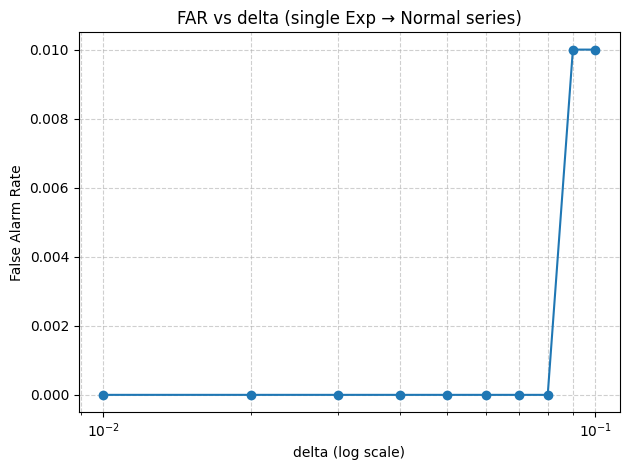

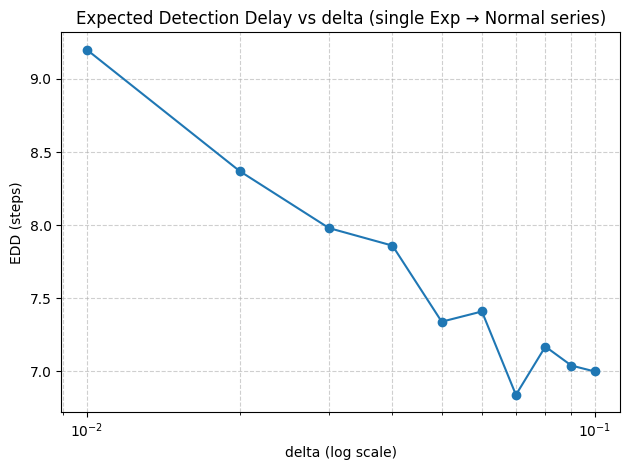

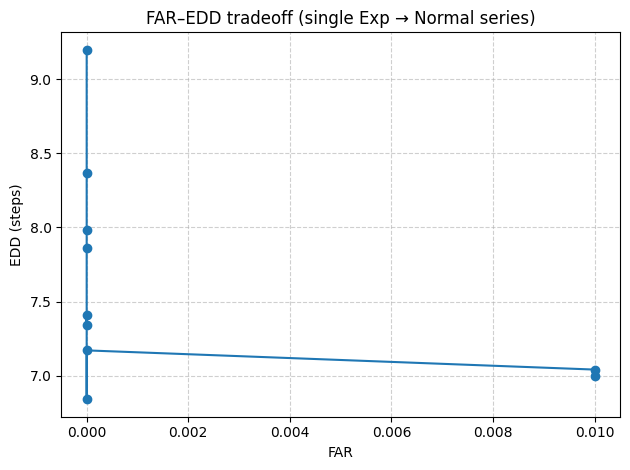

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ==========================================
# 0. Global RNG seed for reproducibility
# ==========================================
MASTER_SEED = 2026
rng_global = np.random.default_rng(MASTER_SEED)
np.random.seed(MASTER_SEED)  # for any legacy np.random.* calls


# ==========================================
# 1. Data generator: single series Exp -> Normal
# ==========================================
def simulate_single_cell(T, t0, lam=1/150, hot_mean=None, sigma=10.0, rng=None):
    """
    Simulate a single series Y_t, t=0,...,T-1:

      - For t < t0:   Y_t ~ Exp(lam)  (mean 1/lam)
      - For t >= t0:  Y_t ~ Normal(hot_mean, sigma^2), truncated at 0

    hot_mean is drawn Uniform(0,150) if not provided, mimicking FakeCalorimeter.
    Returns:
        y        : np.ndarray of shape (T,)
        hot_mean : the hot mean used
    """
    if rng is None:
        rng = rng_global

    if hot_mean is None:
        hot_mean = rng.random() * 150.0  # Uniform(0,150)

    y = np.zeros(T)
    for t in range(T):
        if t < t0:
            # Exp with mean 1/lam
            y[t] = rng.exponential(1.0 / lam)
        else:
            e = rng.normal(hot_mean, sigma)
            y[t] = max(e, 0.0)  # truncate at 0
    return y, hot_mean


# ==========================================
# 2. Log-likelihoods for Exp and Normal
# ==========================================
def exp_loglik_segment(y, a, b, lam):
    """
    log-likelihood under Exp(lam) for y[a:b+1], 0-based indices inclusive.
    """
    seg = y[a:b+1]
    n = seg.size
    return n * np.log(lam) - lam * seg.sum()


def norm_loglik_segment(y, a, b, mu, sigma):
    """
    log-likelihood under N(mu, sigma^2) for y[a:b+1], ignoring truncation.
    """
    seg = y[a:b+1]
    n = seg.size
    return -0.5 * n * np.log(2 * np.pi * sigma**2) - 0.5 * ((seg - mu) ** 2).sum() / sigma**2


# ==========================================
# 3. Amax(t): Exp -> Normal log-BF field
# ==========================================
def Amax_exp_to_norm(y, lam, mu1, sigma):
    """
    Compute A[t] for t=1..T (1-based index) for single series y,
    where the one-change model is Exp(lam) -> N(mu1, sigma^2).

    Model comparison at time t:

      M0: all y[0:t] i.i.d. Exp(lam)
      M1(s): y[0:s-1] Exp(lam), y[s:t] Normal(mu1, sigma^2), s=1..t-1

    A[t] = max_s log BF(s,t) truncated at 0 (i.e. evidence for change at some s).

    Returns:
        A : np.ndarray of length T+1, with:
            A[0] = NaN,
            A[1] = -inf (no split possible),
            A[t] defined for t >= 2.
    """
    T = len(y)
    A = np.full(T + 1, -np.inf, dtype=float)
    A[0] = np.nan

    for t in range(1, T + 1):
        if t < 2:
            continue  # no split possible at t=1
        # No-change log likelihood on 0..t-1
        ell0 = exp_loglik_segment(y, 0, t - 1, lam)
        best = 0.0
        # splits s = 1..t-1 in 1-based -> 0..t-2 in 0-based
        for s in range(1, t):
            ell_exp_1 = exp_loglik_segment(y, 0, s - 1, lam)      # segment 1..s
            ell_norm_2 = norm_loglik_segment(y, s, t - 1, mu1, sigma)  # s+1..t
            logBF = ell_exp_1 + ell_norm_2 - ell0
            if logBF > best:
                best = logBF
        A[t] = max(0.0, best)
    return A


# ==========================================
# 4. Hazard spending & online alarm
# ==========================================
def hazard_logeta(delta, T):
    """
    Compute log hazard spending logeta[t] for t=0..T, 1-based effective:

        logeta[t] = log(delta^2) - (log(t+1) + log log(t+1)), for t>=1
        logeta[0] unused; logeta[1] = -inf (no hazard before t=2)

    Returns:
        logeta : np.ndarray of length T+1
    """
    t = np.arange(T + 1)
    logeta = np.full(T + 1, -np.inf, dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta[1:] = np.log(delta * delta) - (np.log(t[1:] + 1) + np.log(np.log(t[1:] + 1)))
    logeta[0] = np.nan
    logeta[1] = -np.inf  # no hazard at t=1 (no split)
    return logeta


def first_alarm(A, logeta, h=0.0):
    """
    Single-series online alarm:

        S[t] = A[t] + logeta[t]
        alarm at first t with S[t] >= h

    Returns:
        t_alarm : float index (1-based) or np.nan if no alarm.
    """
    S = A + logeta
    for t in range(2, len(S)):  # t>=2
        if S[t] >= h:
            return float(t)
    return np.nan


# ==========================================
# 5. Monte Carlo FAR / EDD vs delta
# ==========================================
if __name__ == "__main__":
    # --- Basic settings ---
    T = 300
    t0 = 150                  # true changepoint
    lam = 1 / 150.0
    sigma_hot = 10.0
    h = 0.0

    R = 100  # number of Monte Carlo runs per delta

    # delta grid to explore
    delta_grid = np.linspace(0.01, 0.1, 10)  # adjust range / density as you like

    rows = []

    for delta in delta_grid:
        alarms = []
        # Get a separate RNG for this delta (optional but cleaner)
        rng_mc = np.random.default_rng(int(rng_global.integers(0, 2**32 - 1)))

        for r in range(R):
            y_r, hot_mean_r = simulate_single_cell(
                T=T, t0=t0, lam=lam, hot_mean=None, sigma=sigma_hot, rng=rng_mc
            )
            A_r = Amax_exp_to_norm(y_r, lam=lam, mu1=hot_mean_r, sigma=sigma_hot)
            logeta_r = hazard_logeta(delta, T)
            t_alarm_r = first_alarm(A_r, logeta_r, h=h)
            alarms.append(t_alarm_r)

        alarms = np.array(alarms)
        finite = np.isfinite(alarms)
        at = alarms[finite]

        if at.size > 0:
            # False Alarm Rate: proportion of alarms that occur before the true change t0
            far = float(np.mean(at < t0))

            # Detection delays for alarms at or after t0
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan

        rows.append({
            "delta": delta,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_alarms": int(at.size),
            "n_post": int(dd.size if at.size > 0 else 0),
        })

    results = pd.DataFrame(rows)
    print(results.head())
    print("\nOverall ranges:")
    print("FAR:", results["FAR"].min(), "→", results["FAR"].max())
    print("EDD:", results["EDD"].min(), "→", results["EDD"].max())

    # ==========================================
    # 6. Plots: FAR vs delta, EDD vs delta, FAR–EDD
    # ==========================================
    plt.figure()
    plt.semilogx(results["delta"], results["FAR"], marker="o")
    plt.xlabel("delta (log scale)")
    plt.ylabel("False Alarm Rate")
    plt.title("FAR vs delta (single Exp → Normal series)")
    plt.grid(True, which="both", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.semilogx(results["delta"], results["EDD"], marker="o")
    plt.xlabel("delta (log scale)")
    plt.ylabel("EDD (steps)")
    plt.title("Expected Detection Delay vs delta (single Exp → Normal series)")
    plt.grid(True, which="both", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(results["FAR"], results["EDD"], marker="o")
    plt.xlabel("FAR")
    plt.ylabel("EDD (steps)")
    plt.title("FAR–EDD tradeoff (single Exp → Normal series)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


Estimated tau (ESS, median over runs): 49.000
     detector  delta   FAR       EDD  EDD_median  n_alarms
0  noncoupled   0.01  0.00  6.310000         6.0       100
1     coupled   0.01  0.00  1.220000         1.0       100
2  noncoupled   0.02  0.01  5.686869         6.0       100
3     coupled   0.02  0.01  1.060606         1.0       100
4  noncoupled   0.03  0.04  5.375000         5.0       100


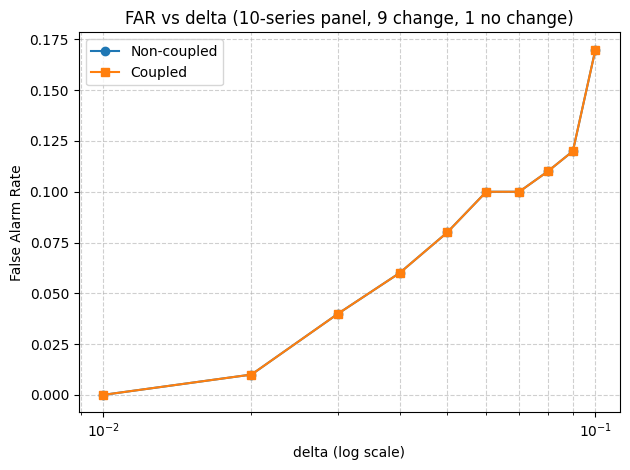

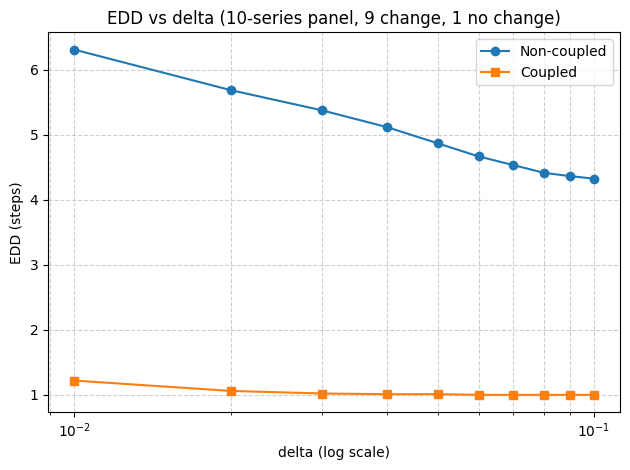

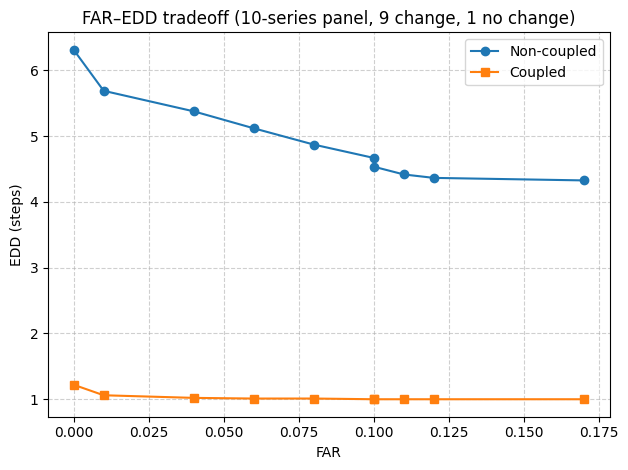

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ==========================================
# 0. Global RNG seed for reproducibility
# ==========================================
MASTER_SEED = 2026
rng_global = np.random.default_rng(MASTER_SEED)
np.random.seed(MASTER_SEED)  # for any legacy np.random.* calls


# ==========================================
# 1. Data generator: single series Exp -> Normal
# ==========================================
def simulate_single_cell(T, t0, lam=1/150, hot_mean=None, sigma=10.0, rng=None):
    """
    Simulate a single series Y_t, t=0,...,T-1:

      - For t < t0:   Y_t ~ Exp(lam)  (mean 1/lam)
      - For t >= t0:  Y_t ~ Normal(hot_mean, sigma^2), truncated at 0

    hot_mean is drawn Uniform(0,150) if not provided, mimicking FakeCalorimeter.
    Returns:
        y        : np.ndarray of shape (T,)
        hot_mean : the hot mean used
    """
    if rng is None:
        rng = rng_global

    if hot_mean is None:
        hot_mean = rng.random() * 150.0  # Uniform(0,150)

    y = np.zeros(T)
    for t in range(T):
        if t < t0:
            # Exp with mean 1/lam
            y[t] = rng.exponential(1.0 / lam)
        else:
            e = rng.normal(hot_mean, sigma)
            y[t] = max(e, 0.0)  # truncate at 0
    return y, hot_mean


# ==========================================
# 2. Log-likelihoods for Exp and Normal
# ==========================================
def exp_loglik_segment(y, a, b, lam):
    """
    log-likelihood under Exp(lam) for y[a:b+1], 0-based indices inclusive.
    """
    seg = y[a:b+1]
    n = seg.size
    return n * np.log(lam) - lam * seg.sum()


def norm_loglik_segment(y, a, b, mu, sigma):
    """
    log-likelihood under N(mu, sigma^2) for y[a:b+1], ignoring truncation.
    """
    seg = y[a:b+1]
    n = seg.size
    return -0.5 * n * np.log(2 * np.pi * sigma**2) - 0.5 * ((seg - mu) ** 2).sum() / sigma**2


# ==========================================
# 3. Amax(t): Exp -> Normal log-BF field (single series)
# ==========================================
def Amax_exp_to_norm(y, lam, mu1, sigma):
    """
    Compute A[t] for t=1..T (1-based index) for single series y,
    where the one-change model is Exp(lam) -> N(mu1, sigma^2).

    Model comparison at time t:

      M0: all y[0:t] i.i.d. Exp(lam)
      M1(s): y[0:s-1] Exp(lam), y[s:t] Normal(mu1, sigma^2), s=1..t-1

    A[t] = max_s log BF(s,t) truncated at 0 (i.e. evidence for change at some s).

    Returns:
        A : np.ndarray of length T+1, with:
            A[0] = NaN,
            A[1] = -inf (no split possible),
            A[t] defined for t >= 2.
    """
    T = len(y)
    A = np.full(T + 1, -np.inf, dtype=float)
    A[0] = np.nan

    for t in range(1, T + 1):
        if t < 2:
            continue  # no split possible at t=1
        # No-change log likelihood on 0..t-1
        ell0 = exp_loglik_segment(y, 0, t - 1, lam)
        best = 0.0
        # splits s = 1..t-1 in 1-based -> 0..t-2 in 0-based
        for s in range(1, t):
            ell_exp_1 = exp_loglik_segment(y, 0, s - 1, lam)      # segment 1..s
            ell_norm_2 = norm_loglik_segment(y, s, t - 1, mu1, sigma)  # s+1..t
            logBF = ell_exp_1 + ell_norm_2 - ell0
            if logBF > best:
                best = logBF
        A[t] = max(0.0, best)
    return A


# ==========================================
# 4. Hazard spending & online alarm (basic)
# ==========================================
def hazard_logeta(delta, T):
    """
    Compute log hazard spending logeta[t] for t=0..T, 1-based effective:

        logeta[t] = log(delta^2) - (log(t+1) + log log(t+1)), for t>=1
        logeta[0] unused; logeta[1] = -inf (no hazard before t=2)

    Returns:
        logeta : np.ndarray of length T+1
    """
    t = np.arange(T + 1)
    logeta = np.full(T + 1, -np.inf, dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta[1:] = np.log(delta * delta) - (np.log(t[1:] + 1) + np.log(np.log(t[1:] + 1)))
    logeta[0] = np.nan
    logeta[1] = -np.inf  # no hazard at t=1 (no split)
    return logeta


def first_alarm_single(A, logeta, h=0.0):
    """
    Single-series online alarm:

        S[t] = A[t] + logeta[t]
        alarm at first t with S[t] >= h

    Returns:
        t_alarm : float index (1-based) or np.nan if no alarm.
    """
    S = A + logeta
    for t in range(2, len(S)):  # t>=2
        if S[t] >= h:
            return float(t)
    return np.nan


# ==========================================
# 5. Panel simulation: 10 series, 9 change, 1 stays Exp
# ==========================================
def simulate_panel(K, T, t0, lam, sigma, rng):
    """
    Simulate a K x T panel.

    For j = 0,...,K-2: series j changes at t0 (Exp -> Normal with its own hot_mean_j).
    For j = K-1: stays Exp forever (no change).

    Returns:
        Y        : (K, T) array
        hot_means: (K,) array of hot means used as mu1_j in Amax; for the
                   unchanged series we still draw a dummy hot_mean for the
                   alternative model (it just never actually appears in data).
    """
    Y = np.zeros((K, T))
    hot_means = np.zeros(K)

    for j in range(K):
        if j < K - 1:
            y_j, mu_j = simulate_single_cell(T, t0, lam=lam, hot_mean=None, sigma=sigma, rng=rng)
            Y[j, :] = y_j
            hot_means[j] = mu_j
        else:
            # Unchanged series: pure Exp(lam) for all t
            Y[j, :] = rng.exponential(1.0 / lam, size=T)
            # Still define an alternative hot mean for the BF model
            hot_means[j] = rng.random() * 150.0
    return Y, hot_means


# ==========================================
# 6. Panel Amax, coupling invariants, and tau estimation
# ==========================================
def precompute_tau_invariants_panel(Y, hot_means, lam, sigma, pi_grp, rho_shrink, t0, clip_neg_bf=True):
    """
    For a K x T panel Y, compute:

      - A_vals[t,j]: per-series Amax (Exp->Normal) log BF
      - logGM_excl[t,j]: leave-one-out log-geomean base over series
      - logs: (log1mp, logp) for group prior pi_grp
      - u_pre: log X_j(t) for t <= t0, used for tau estimation

    Shapes:
      Y: (K, T)
      A_vals: (T+1, K)
      logGM_excl: (T+1, K)
      u_pre: (Tpre, K)
    """
    K, Tlen = Y.shape
    A_vals = np.full((Tlen + 1, K), -np.inf, dtype=float)
    for j in range(K):
        A_vals[:, j] = Amax_exp_to_norm(Y[j, :], lam=lam, mu1=hot_means[j], sigma=sigma)

    # Optional safety: Avals already truncated at 0 inside Amax, but we can ensure non-negative
    A_vals[2:, :] = np.maximum(A_vals[2:, :], 0.0)

    log1mp, logp = np.log(1 - pi_grp), np.log(pi_grp)

    logGM_excl = np.full((Tlen + 1, K), -np.inf, dtype=float)
    u_all      = np.full((Tlen + 1, K), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)

        # logX = log((1-ρ) + ρ * BF)
        logX = np.logaddexp(np.log1p(-rho_shrink), np.log(rho_shrink) + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (K - 1)

    t0_eff = min(t0, Tlen)
    u_pre = u_all[2:t0_eff+1, :].copy()

    return A_vals, logGM_excl, (log1mp, logp), u_pre


def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_j u_j(t)).
    """
    if u_pre.size == 0:
        return 0.0
    var_j = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_j))
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    K = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, K - 1.0))
    return n_eff


# ==========================================
# 7. Panel alarms: coupled vs non-coupled
# ==========================================
def first_alarm_panel(S, h=0.0):
    """
    S: (T+1, K) score matrix.
    Returns first time t where any series has S[t, j] >= h.
    """
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan


def alarm_noncoupled_panel(A_vals, delta, h=0.0):
    """
    Non-coupled detector on panel.
    Global alarm when any series crosses threshold.
    """
    Tlen = A_vals.shape[0] - 1
    logeta = hazard_logeta(delta, Tlen)
    S_n = A_vals + logeta[:, None]
    return first_alarm_panel(S_n, h=h)


def alarm_coupled_panel(A_vals, logGM_excl, logs, delta, tau, h=0.0):
    """
    Coupled detector on panel.
    """
    log1mp, logp = logs
    Tlen, K = A_vals.shape[0] - 1, A_vals.shape[1]

    logeta = hazard_logeta(delta, Tlen)

    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    S_c = A_vals + logLambda + logeta[:, None]
    return first_alarm_panel(S_c, h=h)


# ==========================================
# 8. Monte Carlo experiment: 10-series panel, coupled vs non-coupled
# ==========================================
if __name__ == "__main__":
    # --- Basic settings ---
    K = 50          # number of series
    T = 300
    t0 = 150        # true changepoint (for 9 of them)
    lam = 1 / 150.0
    sigma_hot = 10.0
    h = 0.0

    R = 100         # number of Monte Carlo runs

    pi_grp = 1/1000     # group prior for coupling
    rho_shrink = 0.8

    # delta grid to explore (same as single-series, but you can tweak)
    delta_grid = np.linspace(0.01, 0.1, 10)

    # --- Precompute panel invariants for R runs ---
    precomp_list = []
    tau_hat_runs = []

    for r in range(R):
        rng_mc = np.random.default_rng(int(rng_global.integers(0, 2**32 - 1)))

        Y_panel, hot_means = simulate_panel(
            K=K,
            T=T,
            t0=t0,
            lam=lam,
            sigma=sigma_hot,
            rng=rng_mc,
        )

        A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants_panel(
            Y_panel,
            hot_means,
            lam=lam,
            sigma=sigma_hot,
            pi_grp=pi_grp,
            rho_shrink=rho_shrink,
            t0=t0,
            clip_neg_bf=True,
        )
        tau_hat = estimate_tau_ess_from_u(u_pre)
        tau_hat_runs.append(tau_hat)
        precomp_list.append((A_vals, logGM_excl, logs))

    tau_hat_ESS = float(np.median(tau_hat_runs))
    print(f"Estimated tau (ESS, median over runs): {tau_hat_ESS:.3f}")

    # --- For simplicity, fix tau = median ESS across runs ---
    tau_fixed = 10#tau_hat_ESS

    # --- Sweep delta, compute FAR/EDD for both detectors ---
    rows = []

    for delta in delta_grid:
        alarms_non = []
        alarms_cpl = []

        for (A_vals, logGM_excl, logs) in precomp_list:
            t_n = alarm_noncoupled_panel(A_vals, delta=delta, h=h)
            t_c = alarm_coupled_panel(A_vals, logGM_excl, logs, delta=delta, tau=tau_fixed, h=h)
            alarms_non.append(t_n)
            alarms_cpl.append(t_c)

        alarms_non = np.array(alarms_non)
        alarms_cpl = np.array(alarms_cpl)

        def summarize(alarm_times, label, delta_val):
            finite = np.isfinite(alarm_times)
            at = alarm_times[finite]
            if at.size > 0:
                far = float(np.mean(at < t0))
                dd = at[at >= t0] - t0
                edd = float(np.mean(dd)) if dd.size > 0 else np.nan
                edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
            else:
                far = np.nan
                edd = np.nan
                edd_med = np.nan
            return {
                "detector": label,
                "delta": delta_val,
                "FAR": far,
                "EDD": edd,
                "EDD_median": edd_med,
                "n_alarms": int(at.size),
            }

        rows.append(summarize(alarms_non, "noncoupled", delta))
        rows.append(summarize(alarms_cpl, "coupled", delta))

    results_panel = pd.DataFrame(rows)
    print(results_panel.head())

    # Split into two views
    res_non = results_panel[results_panel["detector"] == "noncoupled"].copy()
    res_cpl = results_panel[results_panel["detector"] == "coupled"].copy()

    # ==========================================
    # 9. Plots: FAR vs delta, EDD vs delta, FAR–EDD
    # ==========================================
    plt.figure()
    plt.semilogx(res_non["delta"], res_non["FAR"], marker="o", label="Non-coupled")
    plt.semilogx(res_cpl["delta"], res_cpl["FAR"], marker="s", label="Coupled")
    plt.xlabel("delta (log scale)")
    plt.ylabel("False Alarm Rate")
    plt.title("FAR vs delta (10-series panel, 9 change, 1 no change)")
    plt.grid(True, which="both", linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.semilogx(res_non["delta"], res_non["EDD"], marker="o", label="Non-coupled")
    plt.semilogx(res_cpl["delta"], res_cpl["EDD"], marker="s", label="Coupled")
    plt.xlabel("delta (log scale)")
    plt.ylabel("EDD (steps)")
    plt.title("EDD vs delta (10-series panel, 9 change, 1 no change)")
    plt.grid(True, which="both", linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(res_non["FAR"], res_non["EDD"], marker="o", label="Non-coupled")
    plt.plot(res_cpl["FAR"], res_cpl["EDD"], marker="s", label="Coupled")
    plt.xlabel("FAR")
    plt.ylabel("EDD (steps)")
    plt.title("FAR–EDD tradeoff (10-series panel, 9 change, 1 no change)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

# ==========================================
# 0. Global RNG seed
# ==========================================
MASTER_SEED = 2026
rng_global = np.random.default_rng(MASTER_SEED)
np.random.seed(MASTER_SEED)


# ==========================================
# 1. Common tau estimators (ESS & K_eff)
# ==========================================
def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_j u_j(t)).

    u_pre: array (Tpre, J) with u_j(t)=log X_j(t) at pre-change times.
    """
    if u_pre.size == 0:
        return 0.0

    # variance over time for each series
    var_j = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_j))

    # average across series at each time; then variance over time
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))

    if vbar <= 0 or var_w <= 0:
        return 0.0

    n_eff = vbar / var_w
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff


def estimate_tau_keff_from_corr(u_pre):
    """
    K_eff-based tau: K_eff = (K-1) / (1 + (K-2)*rho_bar),
    where rho_bar is the mean pairwise correlation of u_j(t) across pre-change t.

    u_pre: array (Tpre, J) with u_j(t).
    Returns (tau_keff, rho_bar).
    """
    if u_pre.size == 0:
        return 0.0, np.nan

    T_pre, J_here = u_pre.shape

    # Corr across series, using time as sample index
    C = np.corrcoef(u_pre, rowvar=False)  # J_here x J_here

    off_diag = C[np.triu_indices(J_here, k=1)]
    mask = ~np.isnan(off_diag)
    if not np.any(mask):
        return 0.0, np.nan

    rho_bar = float(np.mean(off_diag[mask]))

    tau_keff = (J_here - 1.0) / (1.0 + (J_here - 2.0) * rho_bar)
    tau_keff = max(0.0, min(tau_keff, J_here - 1.0))
    return tau_keff, rho_bar


# ==========================================
# 2. Bernoulli / Beta–Binomial pipeline
# ==========================================
def log_beta_vec(a, b):
    return gammaln(a) + gammaln(b) - gammaln(a + b)


def simulate_panel_bern(T, t0, J, num_changed, theta0, theta1, rng):
    """
    Bernoulli panel:
      - For j < num_changed, theta0 pre-change, theta1 post-change.
      - For j >= num_changed, theta0 forever.
    """
    Y = np.zeros((J, T), dtype=int)
    for j in range(J):
        if j < num_changed:
            probs = np.concatenate([np.full(t0, theta0), np.full(T - t0, theta1)])
        else:
            probs = np.full(T, theta0)
        Y[j, :] = rng.binomial(1, probs)
    return Y


def Amax_all_t_bern(prefix_row, alpha, beta):
    """
    Beta–Binomial Amax[t] for t=1..T (run starts at r=1).
    Returns array (T+1,) 1-based; A[1] = -inf (no split possible).
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    m_1t = prefix_row[1:] - prefix_row[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)

    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # L(1,s-1)
        m_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1 = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)

        # L(s,t)
        m_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)

        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)

    return A


def precompute_tau_invariants_bern(Y, alpha, beta, pi, rho, t0, clip_neg_bf=False):
    """
    Bernoulli model:
      - A_vals[t,j]: per-series Amax (Beta–Binomial) log BF
      - logGM_excl[t,j]: leave-one-out log-geomean base over series
      - logs: (log1mp, logp) for group prior pi
      - u_pre[t,j]: log X_j(t) for t<=t0 (pre-change), for tau estimation
    """
    J, Tlen = Y.shape
    prefix = np.zeros((J, Tlen + 1), dtype=int)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(Y[j, :])

    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t_bern(prefix[j], alpha, beta)

    log1mp, logp = np.log(1 - pi), np.log(pi)
    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    u_all = np.full((Tlen + 1, J), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF)
        logX = np.logaddexp(np.log1p(-rho), np.log(rho) + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)

    u_pre = u_all[2:t0+1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre


# ==========================================
# 3. Gamma–Exponential pipeline (new)
# ==========================================
def simulate_panel_exp_gamma(T, t0, J, num_changed, lam0, lam1, rng):
    """
    Exponential panel for Gamma–Exp model:
      - For j < num_changed: Exp(lam0) pre-change, Exp(lam1) post-change.
      - For j >= num_changed: Exp(lam0) forever.
    Only pre-change part matters for tau estimation, but this keeps the same story.
    """
    Y = np.zeros((J, T), dtype=float)
    for j in range(J):
        if j < num_changed:
            # change in rate at t0
            y_pre = rng.exponential(1.0 / lam0, size=t0)
            y_post = rng.exponential(1.0 / lam1, size=T - t0)
            Y[j, :] = np.concatenate([y_pre, y_post])
        else:
            Y[j, :] = rng.exponential(1.0 / lam0, size=T)
    return Y


def Amax_all_t_gammaexp(prefix_row, alpha, beta_rate):
    """
    Gamma–Exponential Amax[t] for t=1..T (run starts at r=1),
    assuming an Exp(λ) likelihood with Gamma(α,β) prior on λ.

    Segment [a..b] (1-based) with n=b-a+1, sum y = S has marginal:

      p(y_{a:b}) ∝ Γ(α+n) / (β+S)^{α+n}  (up to common constants).

    We include the constants α log β - log Γ(α) as they cancel in BFs anyway.
    Returns A[t] for t=1..T in a 1-based array (T+1,), A[1]=-inf.
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    n_1t = np.arange(1, Tlen + 1, dtype=int)
    sum_1t = prefix_row[1:]
    L_1t = (
        alpha * np.log(beta_rate)
        - gammaln(alpha)
        + gammaln(alpha + n_1t)
        - (alpha + n_1t) * np.log(beta_rate + sum_1t)
    )

    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # L(1,s-1)
        n_1_sm1 = s - 1
        sum_1_sm1 = prefix_row[s-1]
        L_1_sm1 = (
            alpha * np.log(beta_rate)
            - gammaln(alpha)
            + gammaln(alpha + n_1_sm1)
            - (alpha + n_1_sm1) * np.log(beta_rate + sum_1_sm1)
        )

        # L(s,t)
        n_s_t = t - s + 1
        sum_s_t = prefix_row[t] - prefix_row[s-1]
        L_s_t = (
            alpha * np.log(beta_rate)
            - gammaln(alpha)
            + gammaln(alpha + n_s_t)
            - (alpha + n_s_t) * np.log(beta_rate + sum_s_t)
        )

        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)

    return A


def precompute_tau_invariants_gammaexp(Y, alpha_g, beta_g, pi, rho, t0, clip_neg_bf=False):
    """
    Gamma–Exp model:
      - A_vals[t,j]: per-series Amax (Gamma–Exp) log BF
      - logGM_excl[t,j]: leave-one-out log-geomean base
      - logs: (log1mp, logp)
      - u_pre[t,j]: u=log X_j(t) for t<=t0
    """
    J, Tlen = Y.shape
    prefix = np.zeros((J, Tlen + 1), dtype=float)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(Y[j, :])

    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t_gammaexp(prefix[j], alpha_g, beta_g)

    log1mp, logp = np.log(1 - pi), np.log(pi)
    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    u_all = np.full((Tlen + 1, J), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        logX = np.logaddexp(np.log1p(-rho), np.log(rho) + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)

    u_pre = u_all[2:t0+1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre


# ==========================================
# 4. Exp -> Normal pipeline (your original toy)
# ==========================================
def simulate_single_cell(T, t0, lam=1/150, hot_mean=None, sigma=10.0, rng=None):
    """
    Simulate a single series Y_t, t=0,...,T-1:

      - For t < t0:   Y_t ~ Exp(lam)  (mean 1/lam)
      - For t >= t0:  Y_t ~ Normal(hot_mean, sigma^2), truncated at 0
    """
    if rng is None:
        rng = rng_global

    if hot_mean is None:
        hot_mean = rng.random() * 150.0  # Uniform(0,150)

    y = np.zeros(T)
    for t in range(T):
        if t < t0:
            y[t] = rng.exponential(1.0 / lam)
        else:
            e = rng.normal(hot_mean, sigma)
            y[t] = max(e, 0.0)  # truncate at 0
    return y, hot_mean


def exp_loglik_segment(y, a, b, lam):
    seg = y[a:b+1]
    n = seg.size
    return n * np.log(lam) - lam * seg.sum()


def norm_loglik_segment(y, a, b, mu, sigma):
    seg = y[a:b+1]
    n = seg.size
    return -0.5 * n * np.log(2 * np.pi * sigma**2) - 0.5 * ((seg - mu) ** 2).sum() / sigma**2


def Amax_exp_to_norm(y, lam, mu1, sigma):
    """
    A[t] for t=1..T (1-based) for Exp(lam) -> N(mu1, sigma^2) change model.
    """
    T = len(y)
    A = np.full(T + 1, -np.inf, dtype=float)
    A[0] = np.nan

    for t in range(1, T + 1):
        if t < 2:
            continue
        ell0 = exp_loglik_segment(y, 0, t - 1, lam)
        best = 0.0
        for s in range(1, t):
            ell_exp_1 = exp_loglik_segment(y, 0, s - 1, lam)
            ell_norm_2 = norm_loglik_segment(y, s, t - 1, mu1, sigma)
            logBF = ell_exp_1 + ell_norm_2 - ell0
            if logBF > best:
                best = logBF
        A[t] = max(0.0, best)
    return A


def simulate_panel_expnorm(K, T, t0, lam, sigma, rng):
    """
    Panel for Exp -> Normal toy:

      - For j = 0,...,K-2: change at t0 (Exp -> Normal with its own hot_mean_j).
      - For j = K-1: stays Exp(lam) forever.
    """
    Y = np.zeros((K, T))
    hot_means = np.zeros(K)

    for j in range(K):
        if j < K - 1:
            y_j, mu_j = simulate_single_cell(T, t0, lam=lam, hot_mean=None, sigma=sigma, rng=rng)
            Y[j, :] = y_j
            hot_means[j] = mu_j
        else:
            Y[j, :] = rng.exponential(1.0 / lam, size=T)
            hot_means[j] = rng.random() * 150.0
    return Y, hot_means


def precompute_tau_invariants_expnorm(Y, hot_means, lam, sigma, pi_grp, rho_shrink, t0, clip_neg_bf=False):
    """
    Exp->Normal toy:
      - A_vals[t,j]: per-series Amax (Exp->Normal) log BF
      - logGM_excl[t,j]: leave-one-out log-geomean base
      - logs: (log1mp, logp)
      - u_pre[t,j]: log X_j(t) for t<=t0
    """
    K, Tlen = Y.shape
    A_vals = np.full((Tlen + 1, K), -np.inf, dtype=float)
    for j in range(K):
        A_vals[:, j] = Amax_exp_to_norm(Y[j, :], lam=lam, mu1=hot_means[j], sigma=sigma)

    # ensure non-negative if desired (A already truncated inside, but keep option)
    if clip_neg_bf:
        A_vals[2:, :] = np.maximum(A_vals[2:, :], 0.0)

    log1mp, logp = np.log(1 - pi_grp), np.log(pi_grp)

    logGM_excl = np.full((Tlen + 1, K), -np.inf, dtype=float)
    u_all = np.full((Tlen + 1, K), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        logX = np.logaddexp(np.log1p(-rho_shrink), np.log(rho_shrink) + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (K - 1)

    t0_eff = min(t0, Tlen)
    u_pre = u_all[2:t0_eff+1, :].copy()

    return A_vals, logGM_excl, (log1mp, logp), u_pre


# ==========================================
# 5. Main: compare tau-hats across 3 models
# ==========================================
if __name__ == "__main__":
    # Panel & experiment settings
    J = 50          # number of series
    T = 200
    t0 = 100
    num_changed = 40

    # Bernoulli parameters
    theta0 = 0.2
    theta1 = 0.4
    alpha_bb = 1.0
    beta_bb = 1.0

    # Exponential parameters (shared for Exp models)
    lam0 = 1 / 150.0   # pre-change rate
    lam1 = 1 / 100.0   # post-change rate (Gamma–Exp toy)
    sigma_hot = 10.0   # for Exp->Normal toy

    # Coupling hyperparameters
    pi_grp = 1/1000
    rho_shrink = 0.8
    CLIP_NEG_BF = False   # use same setting for all three

    R = 200  # Monte Carlo runs

    # Storage for tau-hats
    tau_bern_ESS, tau_bern_KEFF, rho_bern = [], [], []
    tau_gexp_ESS, tau_gexp_KEFF, rho_gexp = [], [], []
    tau_en_ESS,   tau_en_KEFF,   rho_en   = [], [], []

    # Gamma prior for Gamma–Exp: mean(alpha_g/beta_g) ~ lam0
    alpha_g = 1.0
    beta_g = alpha_g / lam0   # so E[λ]=lam0

    for r in range(R):
        rng_mc = np.random.default_rng(int(rng_global.integers(0, 2**32 - 1)))

        # --- 1) Bernoulli / Beta–Binomial ---
        Y_bern = simulate_panel_bern(T, t0, J, num_changed, theta0, theta1, rng_mc)
        _, _, _, u_pre_bern = precompute_tau_invariants_bern(
            Y_bern, alpha_bb, beta_bb, pi_grp, rho_shrink, t0, clip_neg_bf=CLIP_NEG_BF
        )
        tau_b_ess = estimate_tau_ess_from_u(u_pre_bern)
        tau_b_keff, rho_b = estimate_tau_keff_from_corr(u_pre_bern)
        tau_bern_ESS.append(tau_b_ess)
        tau_bern_KEFF.append(tau_b_keff)
        rho_bern.append(rho_b)

        # --- 2) Gamma–Exponential ---
        Y_gexp = simulate_panel_exp_gamma(T, t0, J, num_changed, lam0, lam1, rng_mc)
        _, _, _, u_pre_gexp = precompute_tau_invariants_gammaexp(
            Y_gexp, alpha_g, beta_g, pi_grp, rho_shrink, t0, clip_neg_bf=CLIP_NEG_BF
        )
        tau_g_ess = estimate_tau_ess_from_u(u_pre_gexp)
        tau_g_keff, rho_g = estimate_tau_keff_from_corr(u_pre_gexp)
        tau_gexp_ESS.append(tau_g_ess)
        tau_gexp_KEFF.append(tau_g_keff)
        rho_gexp.append(rho_g)

        # --- 3) Exp -> Normal ---
        Y_en, hot_means = simulate_panel_expnorm(J, T, t0, lam0, sigma_hot, rng_mc)
        _, _, _, u_pre_en = precompute_tau_invariants_expnorm(
            Y_en, hot_means, lam0, sigma_hot, pi_grp, rho_shrink, t0, clip_neg_bf=CLIP_NEG_BF
        )
        tau_en_ess = estimate_tau_ess_from_u(u_pre_en)
        tau_en_keff, rho_e = estimate_tau_keff_from_corr(u_pre_en)
        tau_en_ESS.append(tau_en_ess)
        tau_en_KEFF.append(tau_en_keff)
        rho_en.append(rho_e)

    # Summaries
    def summarize(name, tau_ess, tau_keff, rho_list):
        print(f"\n=== {name} ===")
        print(f"Median τ̂_ESS : {np.median(tau_ess):.3f}")
        print(f"Median τ̃_Keff: {np.median(tau_keff):.3f}")
        print(f"Median ρ̄     : {np.nanmedian(rho_list):.4f}")

    summarize("Bernoulli / Beta–Binomial", tau_bern_ESS, tau_bern_KEFF, rho_bern)
    summarize("Exponential / Gamma–Exponential", tau_gexp_ESS, tau_gexp_KEFF, rho_gexp)
    summarize("Exp -> Normal (fixed λ, μ, σ)", tau_en_ESS, tau_en_KEFF, rho_en)



=== Bernoulli / Beta–Binomial ===
Median τ̂_ESS : 11.274
Median τ̃_Keff: 11.583
Median ρ̄     : 0.0673

=== Exponential / Gamma–Exponential ===
Median τ̂_ESS : 13.575
Median τ̃_Keff: 15.957
Median ρ̄     : 0.0431

=== Exp -> Normal (fixed λ, μ, σ) ===
Median τ̂_ESS : 49.000
Median τ̃_Keff: 49.000
Median ρ̄     : -0.0002
